# Challenge 2 : phishing websites detection

Common imports :

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas.api.types as ptypes
import seaborn as sns
import numpy as np

## Data Analysis

### Dropping / adding features 

In this part, we first drop the columns we do not want and then, we will analyze the data to understand it and transform it to improve the future training (drop features, create features, hilights the need to scale, ...)

Adding some features to our dataset could improve the model performance. 
By introducing the following ones, being meaningful feature combinations, we hope to capture complex relationships between variables that might not be obvious from original features. Moreover, approximating some non-linear relationships could make the model more expressive and reduce model bias. 

For example, a high media resource intensity could show a well developed and professional website. This is represented by the amount of image, CSS and JS combined. Creating a ratio in the formula also enhance the meaning of the variable compared to a raw sum of variables.

In [2]:
def drop_add_columns(df): 
    # REMOVING FEATURES
    df.drop(columns=['Unnamed: 0', 'URLSimilarityIndex', 'CharContinuationRate', 'URLTitleMatchScore', 'URLCharProb','TLDLegitimateProb'], inplace=True)
    
    # ADDING FEATURES   
    # A high intensity of obfuscated character could be suspicious
    df['ObfuscationIntensity'] = df['NoOfObfuscatedChar'] / df['DomainLength']

    # Many interactions on a web page could be suspicious 
    # Phising web sites could use pop ups and hidden fields to trap the victimes
    df['InteractionRiskIndex'] = df['NoOfPopup'] + df['HasExternalFormSubmit'] + df['HasHiddenFields']

    # A high media resource intensity could show a well developed and professional website 
    df['MediaResourceIntensity'] = (df['NoOfImage'] + df['NoOfCSS'] + df['NoOfJS']) / df['URLLength']

    # Hackers use interaction tools to collect sensitive informations
    df['InteractionRichness'] = df['HasSubmitButton'] + df['HasPasswordField'] + df['HasSocialNet']
    df['FormSecurityFlags'] = df['HasSubmitButton'] + df['HasPasswordField'] + df['HasExternalFormSubmit'] + df['HasHiddenFields']

    # Hackers use redirection to trap people
    df['RedirectionRisk'] = df['NoOfURLRedirect'] + df['NoOfSelfRedirect']

In [3]:
train = pd.read_csv('Training_for_evaluation.csv')
test = pd.read_csv('Testing_for_evaluation.csv')

drop_add_columns(train)
drop_add_columns(test)
train.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,TLDLength,NoOfSubDomain,HasObfuscation,...,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label,ObfuscationIntensity,InteractionRiskIndex,MediaResourceIntensity,InteractionRichness,FormSecurityFlags,RedirectionRisk
0,oph03490.txt,https://2alb-atfal.com/wp-content/mu-plugins/m...,61,2alb-atfal.com,14,0,com,3,0,0,...,0,0,2,0,0.0,0,0.032787,2,2,0
1,8091729.txt,http://www.saisoncard.co.jp.50gb990.xyz/,40,www.saisoncard.co.jp.50gb990.xyz,32,0,xyz,3,4,0,...,0,0,0,0,0.0,0,0.050000,0,0,0
2,8039768.txt,https://cllc08.firebaseapp.com/,30,cllc08.firebaseapp.com,22,0,com,3,1,0,...,0,0,3,0,0.0,0,0.000000,0,0,0
3,8054392.txt,https://sijklnkl8nvb.web.app/,29,sijklnkl8nvb.web.app,20,0,app,3,1,0,...,0,0,3,0,0.0,0,0.000000,0,0,0
4,8077418.txt,https://rb.gy/e9x2iq,20,rb.gy,5,0,gy,2,0,0,...,0,0,0,0,0.0,0,0.000000,0,0,0


### Missing values and data types

In [105]:
missing_values = train.isnull().mean()
print(missing_values[missing_values>0])
missing_values = test.isnull().mean()
print(missing_values[missing_values>0])

Series([], dtype: float64)
Series([], dtype: float64)


No missing values ! (missing_values is empty)

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100420 entries, 0 to 100419
Data columns (total 57 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    100420 non-null  object 
 1   URL                         100420 non-null  object 
 2   URLLength                   100420 non-null  int64  
 3   Domain                      100420 non-null  object 
 4   DomainLength                100420 non-null  int64  
 5   IsDomainIP                  100420 non-null  int64  
 6   TLD                         100420 non-null  object 
 7   TLDLength                   100420 non-null  int64  
 8   NoOfSubDomain               100420 non-null  int64  
 9   HasObfuscation              100420 non-null  int64  
 10  NoOfObfuscatedChar          100420 non-null  int64  
 11  ObfuscationRatio            100420 non-null  float64
 12  NoOfLettersInURL            100420 non-null  int64  
 13  LetterRatioInU

In [11]:
already_encoded = []
for col in train.columns.to_list():
    if col.startswith('Has'):
        print(col, train[col].unique())
        already_encoded.append(col) # we already know it's 0,1 so it can be added
    elif col.startswith('Is'):
        print(col, train[col].unique())
        already_encoded.append(col) # we already know it's 0,1 so it can be added

IsDomainIP [0 1]
HasObfuscation [0 1]
IsHTTPS [1 0]
HasTitle [1 0]
HasFavicon [1 0]
IsResponsive [1 0]
HasDescription [1 0]
HasExternalFormSubmit [0 1]
HasSocialNet [0 1]
HasSubmitButton [1 0]
HasHiddenFields [0 1]
HasPasswordField [1 0]
HasCopyrightInfo [1 0]


A lot of numerical features but we can see many categorical (binary) features which are already encoded (the cell above). We should keep this information in our mind if we want to drop it or not before training some models (especially the ones based on only numerical data). However, in our opinion, as it is only binary values, it's not so disturbing because the order means something, but if there was more than 2 unordered possible values, we have to drop them for this kind of model.

There are also a few categorical features we will analyze in the following cells.

In [41]:
stats = train.describe()
variances = train.select_dtypes(exclude='object').var()
stats.loc['variance'] = variances
stats.T

,count,mean,std,min,25%,50%,75%,max,variance
URLLength,100420.0,27.444941,14.438085,14.0,23.000000,26.000000,30.000,1.407000e+03,2.084583e+02
DomainLength,100420.0,19.556572,5.711885,4.0,16.000000,19.000000,23.000,9.300000e+01,3.262563e+01
IsDomainIP,100420.0,0.000408,0.020202,0.0,0.000000,0.000000,0.000,1.000000e+00,4.081226e-04
TLDLength,100420.0,2.729187,0.530681,2.0,2.000000,3.000000,3.000,1.100000e+01,2.816225e-01
NoOfSubDomain,100420.0,1.162249,0.436345,0.0,1.000000,1.000000,1.000,5.000000e+00,1.903971e-01
HasObfuscation,100420.0,0.000229,0.015132,0.0,0.000000,0.000000,0.000,1.000000e+00,2.289879e-04
NoOfObfuscatedChar,100420.0,0.001344,0.104129,0.0,0.000000,0.000000,0.000,1.200000e+01,1.084275e-02
ObfuscationRatio,100420.0,0.000012,0.000928,0.0,0.000000,0.000000,0.000,1.280000e-01,8.618509e-07
NoOfLettersInURL,100420.0,13.882444,11.203671,0.0,10.000000,13.000000,16.000,1.095000e+03,1.255222e+02
LetterRatioInURL,100420.0,0.482269,0.100707,0.0,0.409000,0.481000,0.552,8.670000e-01,1.014183e-02


### Encoding 
- first we identify the categories in each categorical column and reports the number of categories 
- then, we transform the categorical data into numerical 
- finally, we compute the variance of the encoded values for each colum, to have some insights into the distribution of the categories 

In [14]:
categories = {}
var = {}
data = pd.DataFrame()

for col in train.select_dtypes(include='object').columns:
    categories[col] = train[col].unique().tolist()
    data[col + '_encoded'] = train[col].astype('category').cat.codes
    variance = data[col + '_encoded'].var()
    var[col] = variance

for col, cat in categories.items():
    print(f"Column '{col}' : {len(cat)} categories and var = {var[col]}")

Column 'FILENAME' : 100420 categories and var = 840356401.6666666
Column 'URL' : 100419 categories and var = 840355865.5597256
Column 'Domain' : 99987 categories and var = 839199089.1317545
Column 'TLD' : 501 categories and var = 13786.21558698123
Column 'Title' : 97459 categories and var = 823413272.206214


URL, FILENAME, Domain, Title seem to be unique for almost every individual : we can drop them because they won't give information (except if we use NN to understand the meaning inside these features but we won't).

In [4]:
train.drop(columns=['URL', 'FILENAME', 'Title', 'Domain'], inplace=True)
test.drop(columns=['URL', 'FILENAME', 'Title', 'Domain'], inplace=True)

# Correlation , scatterplot
To visualize the relationship between two continuous variables, we use scatterplots. These latter allow us to visually assess the strength, direction and form of the relationship. 
This will help us in our feature selection. If we identify strong correlations for example, it means that the features are redundant and one may be removed to simplify the model without losing much information. 

In [5]:
dfnum = train.select_dtypes(include=['number'])

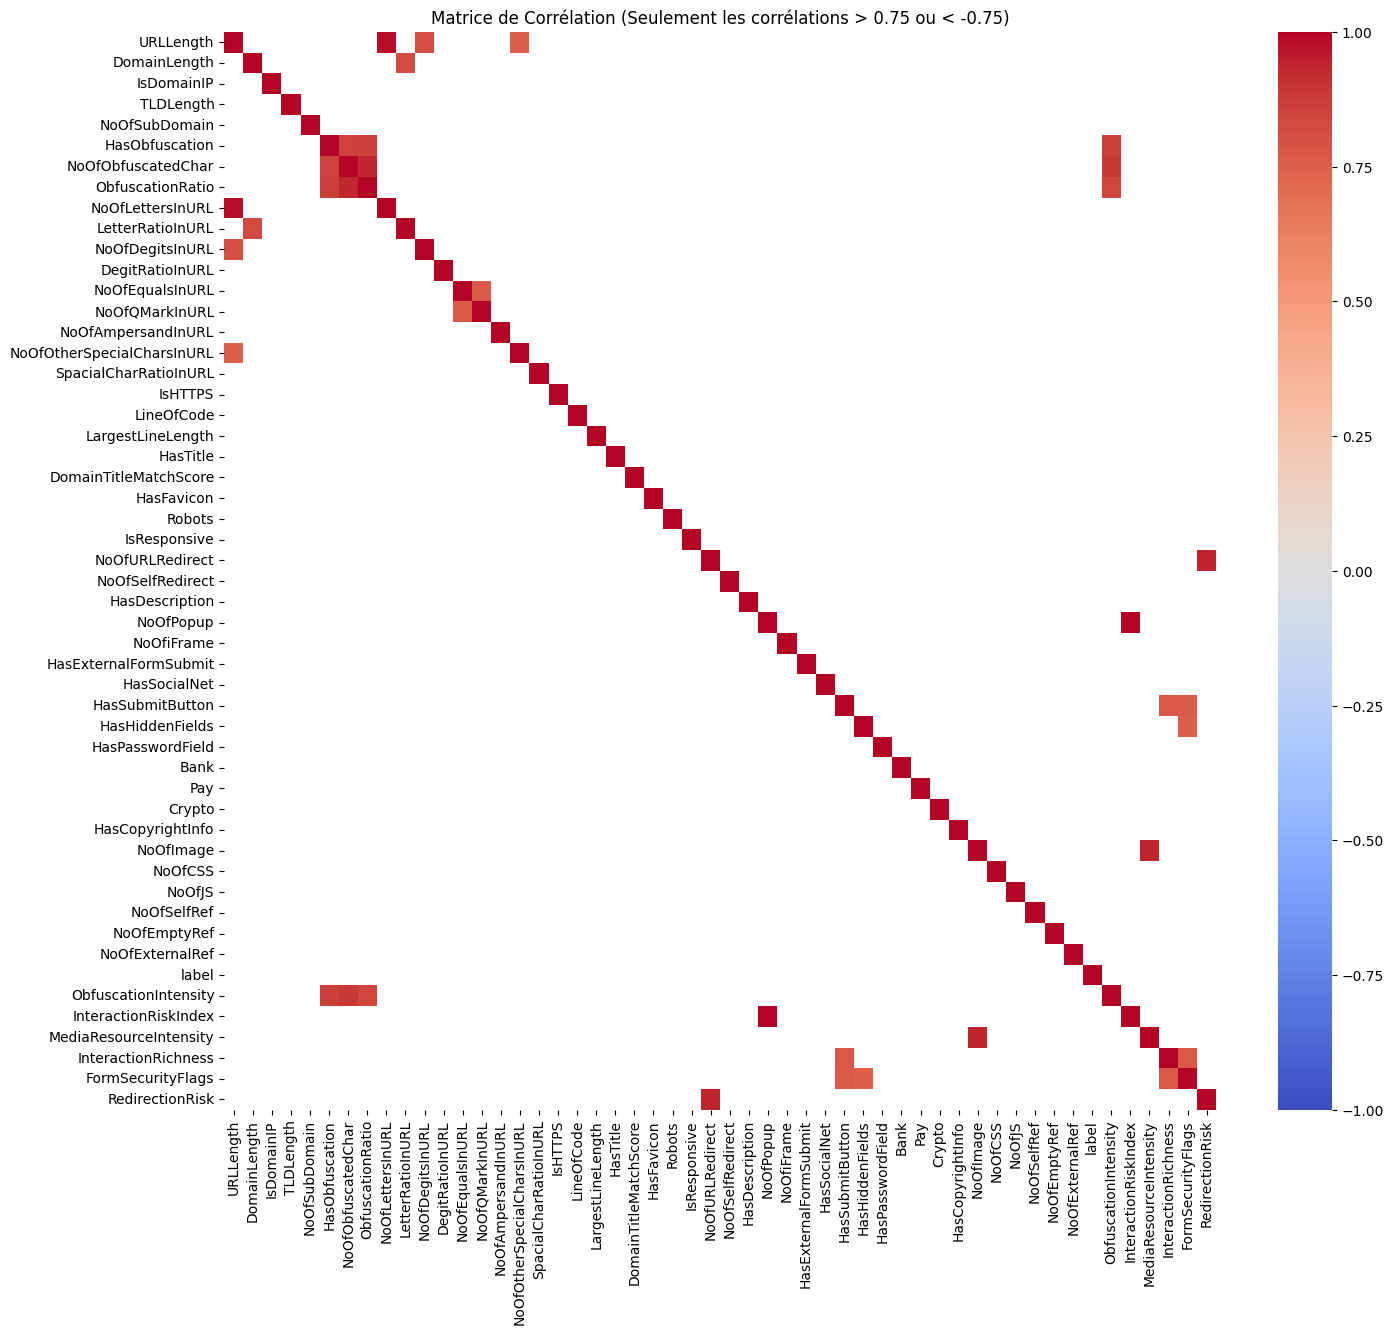

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix_pearson = dfnum.corr(method='pearson')

filtered_correlation_matrix = correlation_matrix_pearson.where(np.abs(correlation_matrix_pearson) > 0.75)
plt.figure(figsize=(16, 14))
sns.heatmap(filtered_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, mask=filtered_correlation_matrix.isnull())
plt.title("Matrice de Corrélation (Seulement les corrélations > 0.75 ou < -0.75)")
plt.show()


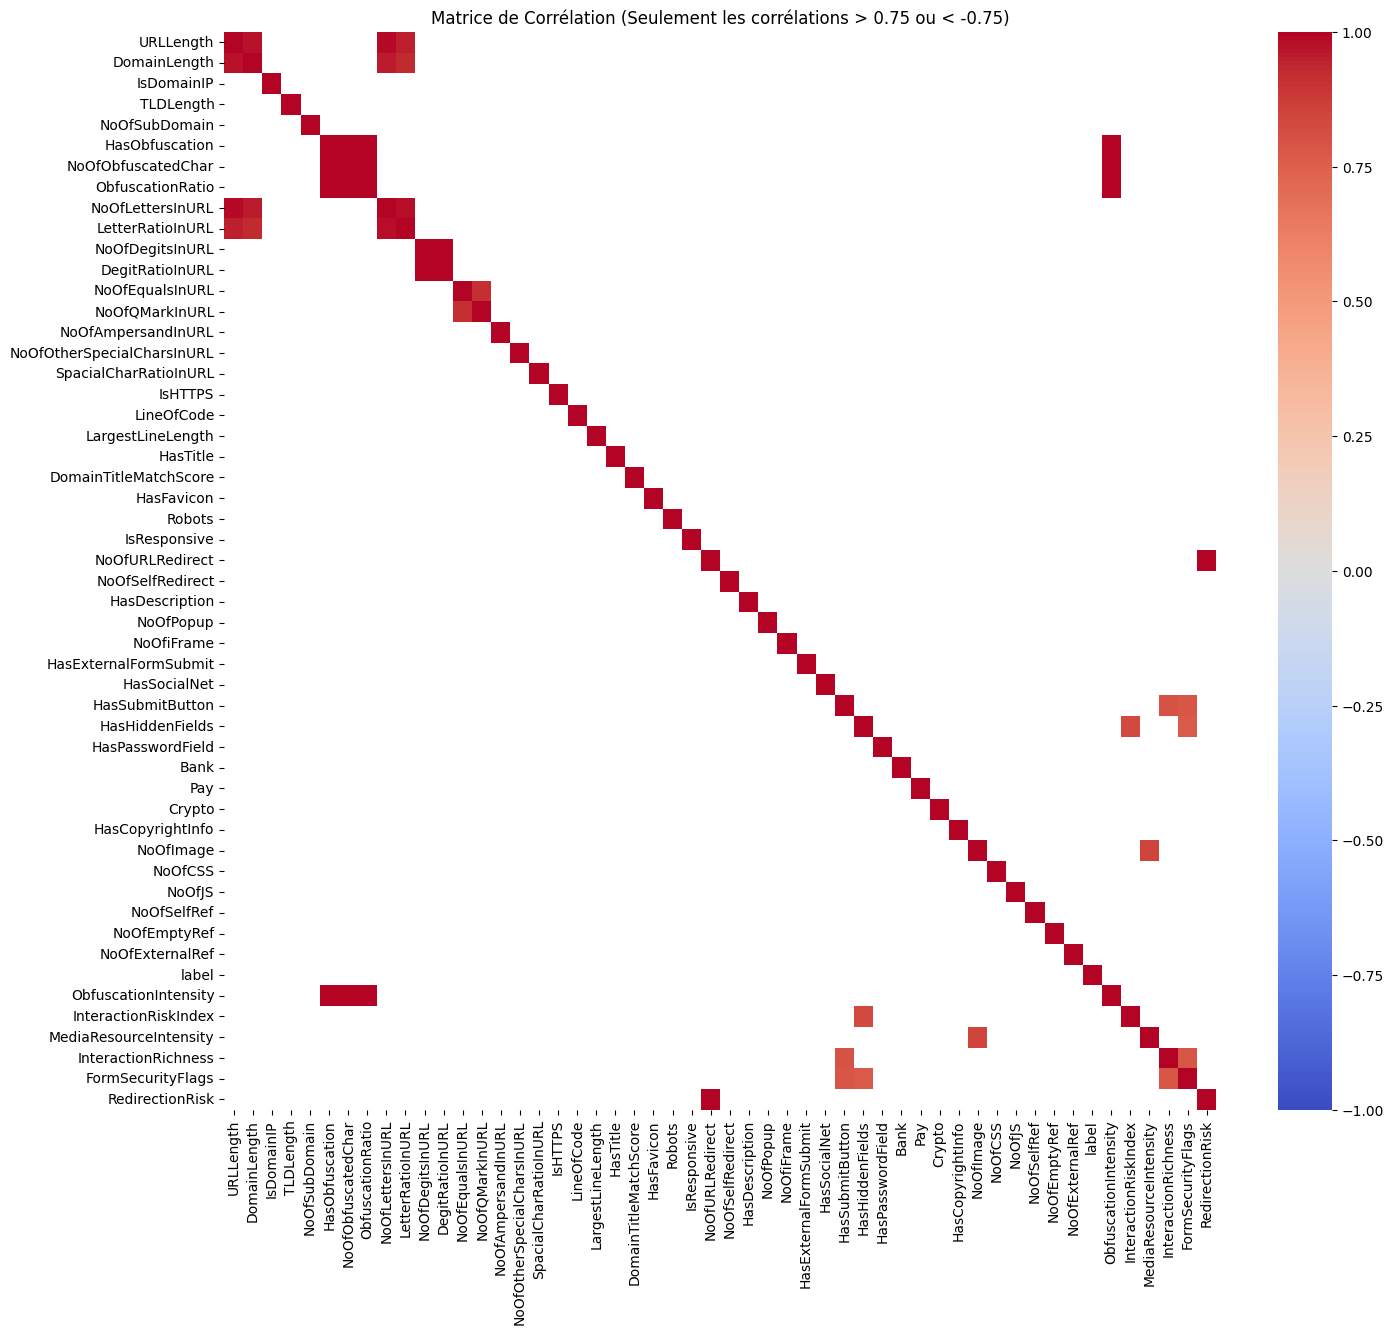

In [9]:
correlation_matrix_spearman = dfnum.corr(method='spearman')

filtered_correlation_matrix = correlation_matrix_spearman.where(np.abs(correlation_matrix_spearman) > 0.75)
plt.figure(figsize=(16, 14))
sns.heatmap(filtered_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, mask=filtered_correlation_matrix.isnull())
plt.title("Matrice de Corrélation (Seulement les corrélations > 0.75 ou < -0.75)")
plt.show()

We can see a lot of strong correlation between some features. Considering that, some features can be removed to make the model easier to train and understand. 

In [12]:
def correlation_drop(df) :
    columns = ['HasObfuscation', 'NoOfObfuscatedChar','NoOfDegitsInURL','NoOfLettersInURL', 'DomainLength',
               'NoOfURLRedirect']
    df.drop(columns=columns, inplace=True)

already_encoded.remove('HasObfuscation') # to avoid future errors

correlation_drop(train)
correlation_drop(test)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100420 entries, 0 to 100419
Data columns (total 47 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   URLLength                   100420 non-null  int64  
 1   IsDomainIP                  100420 non-null  int64  
 2   TLD                         100420 non-null  object 
 3   TLDLength                   100420 non-null  int64  
 4   NoOfSubDomain               100420 non-null  int64  
 5   ObfuscationRatio            100420 non-null  float64
 6   LetterRatioInURL            100420 non-null  float64
 7   DegitRatioInURL             100420 non-null  float64
 8   NoOfEqualsInURL             100420 non-null  int64  
 9   NoOfQMarkInURL              100420 non-null  int64  
 10  NoOfAmpersandInURL          100420 non-null  int64  
 11  NoOfOtherSpecialCharsInURL  100420 non-null  int64  
 12  SpacialCharRatioInURL       100420 non-null  float64
 13  IsHTTPS       

In [13]:
already_encoded

['IsDomainIP',
 'IsHTTPS',
 'HasTitle',
 'HasFavicon',
 'IsResponsive',
 'HasDescription',
 'HasExternalFormSubmit',
 'HasSocialNet',
 'HasSubmitButton',
 'HasHiddenFields',
 'HasPasswordField',
 'HasCopyrightInfo']

The selected columns have been droped well.

## Variable distribution and outliers (boxplots)

To see the distribution of numeric variables and potential outliers, we use boxplots. 
They are useful to identify patterns and potential issues in the data. Complementing them to the correlation analysis is efficient because outliers can affect correlation coefficients.



In [14]:
def draw_boxplots(df):
    for column in df.columns:
        if ptypes.is_numeric_dtype(df[column]):
            plt.figure(figsize=(8, 6))
            sns.boxplot(x=column, data=df, orient='v')
            plt.title(f'Boxplot of {column}')
            plt.show()

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


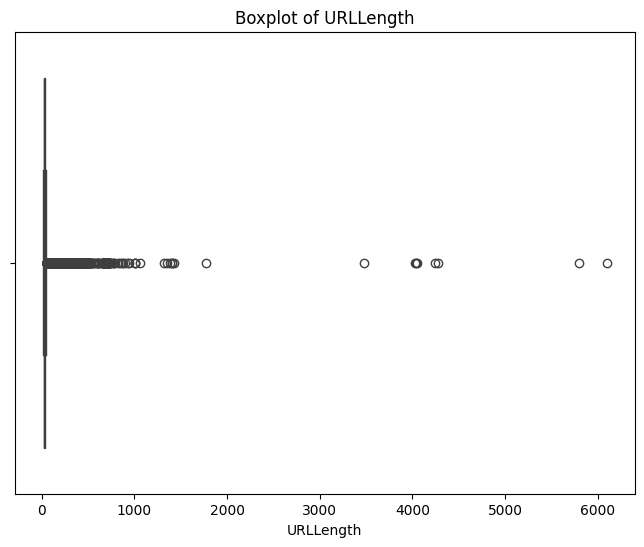

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


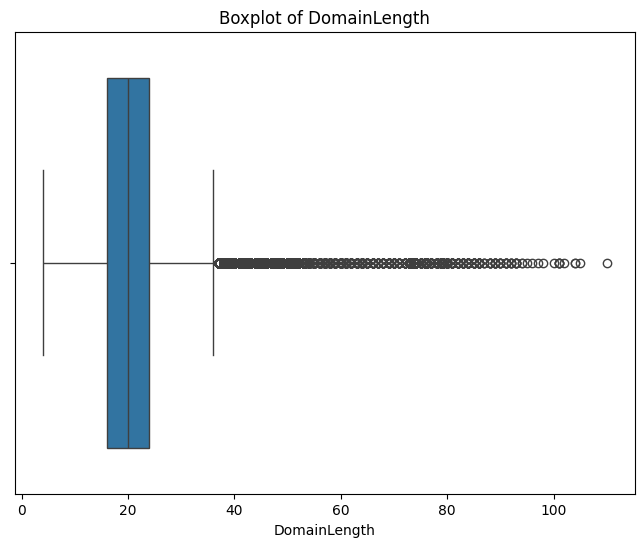

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


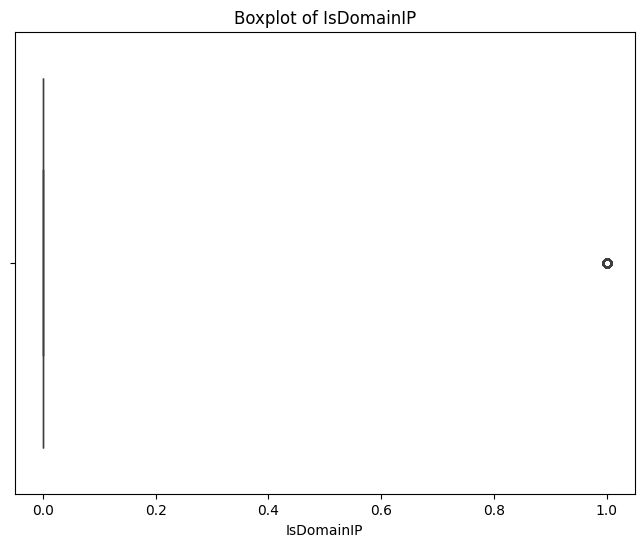

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


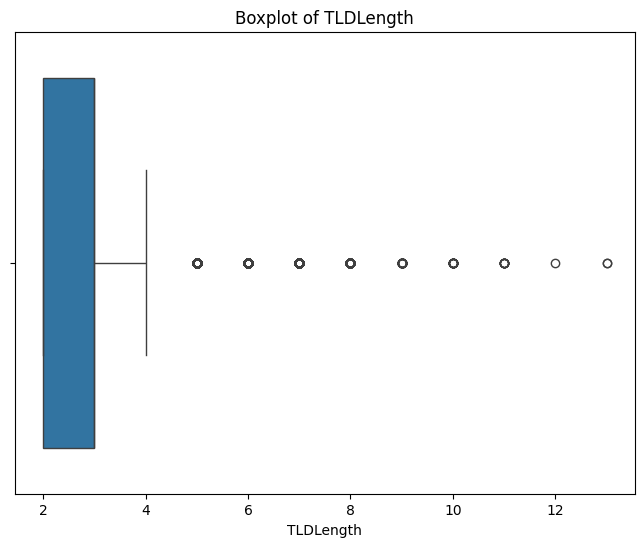

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


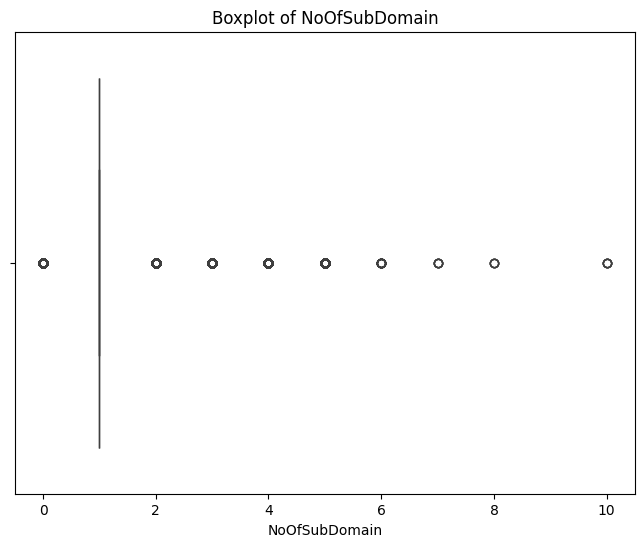

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


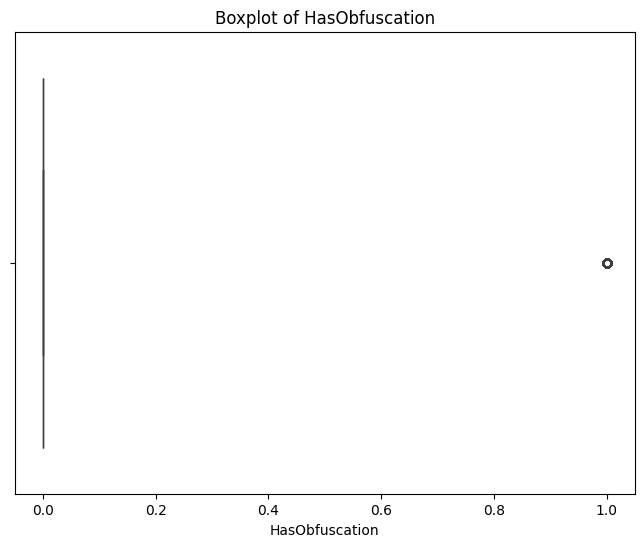

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


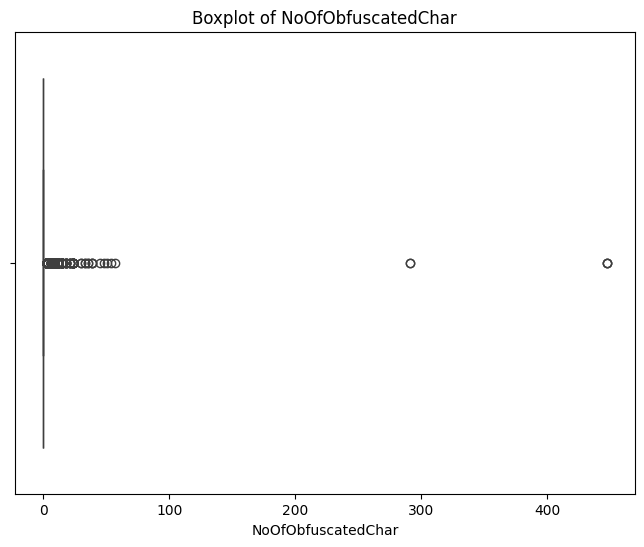

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


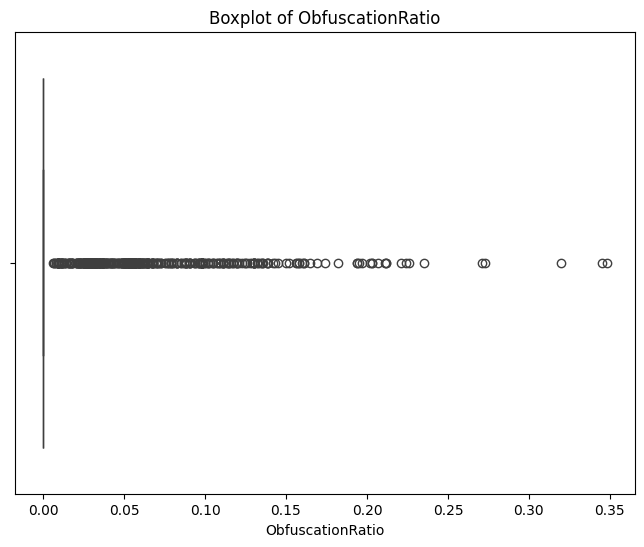

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


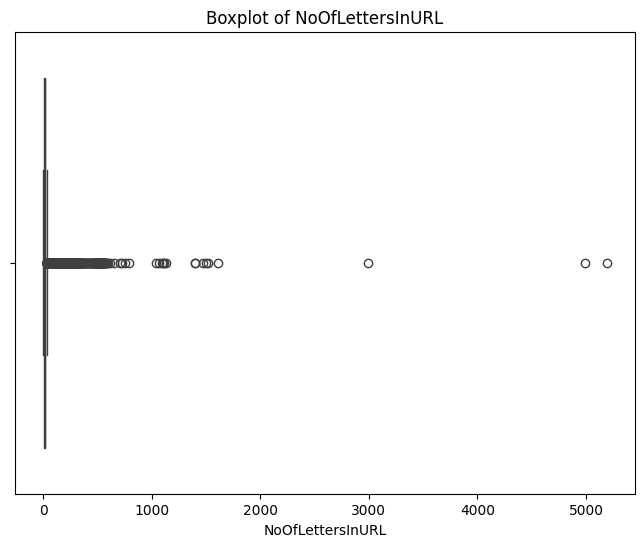

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


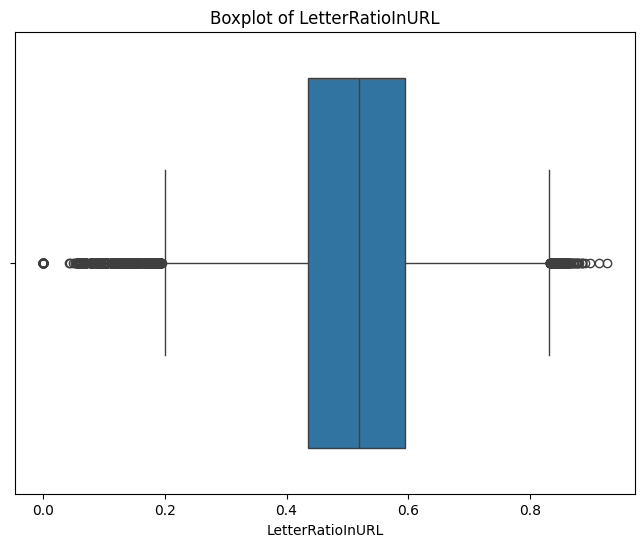

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


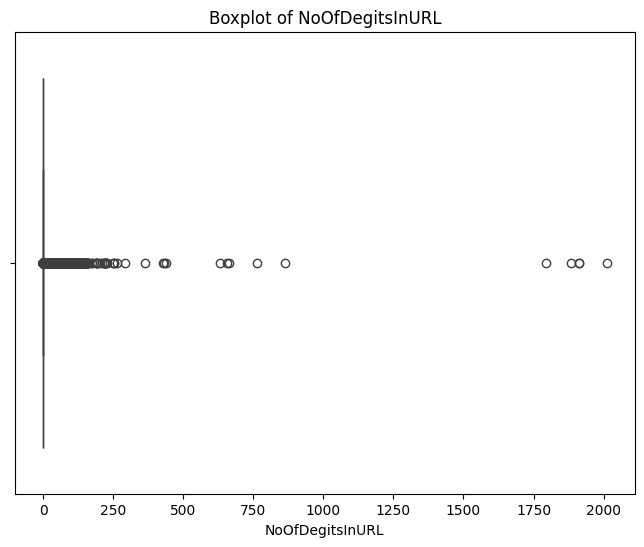

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


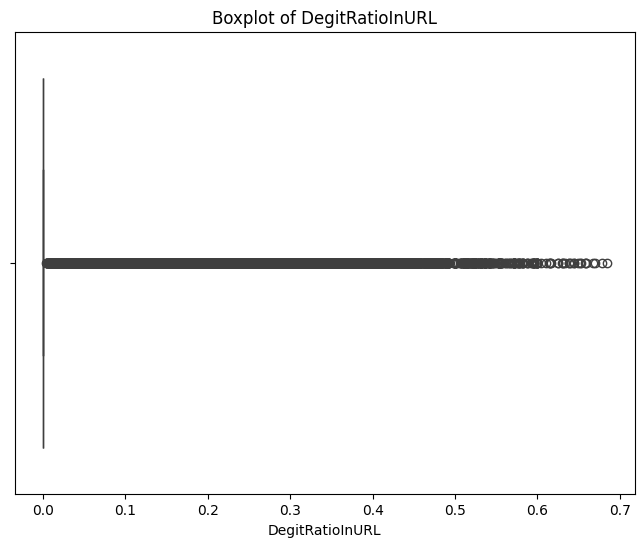

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


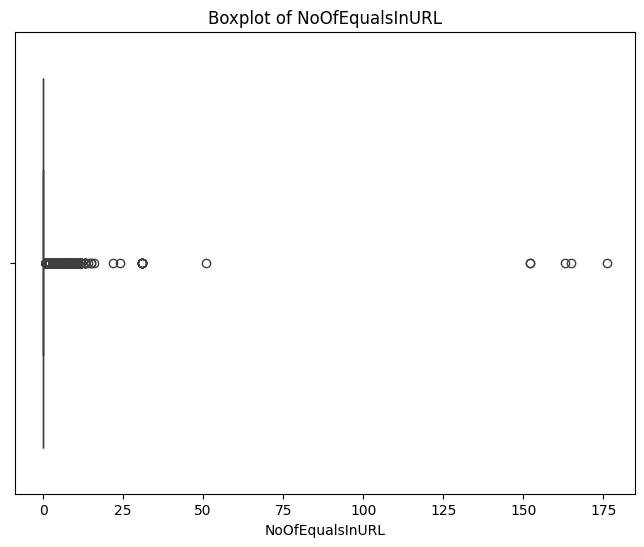

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


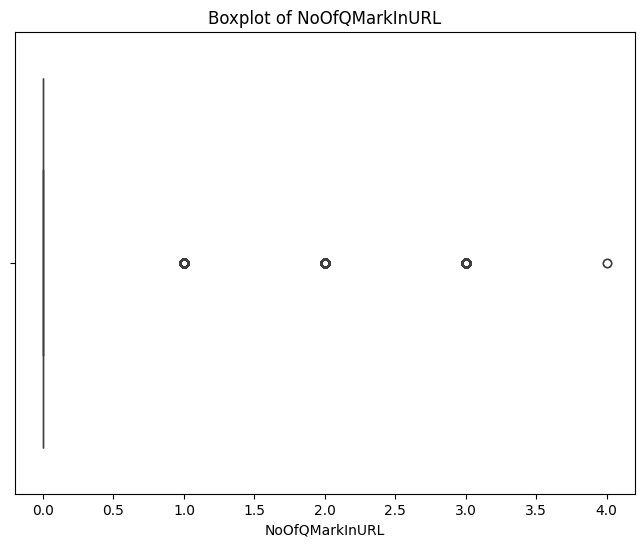

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


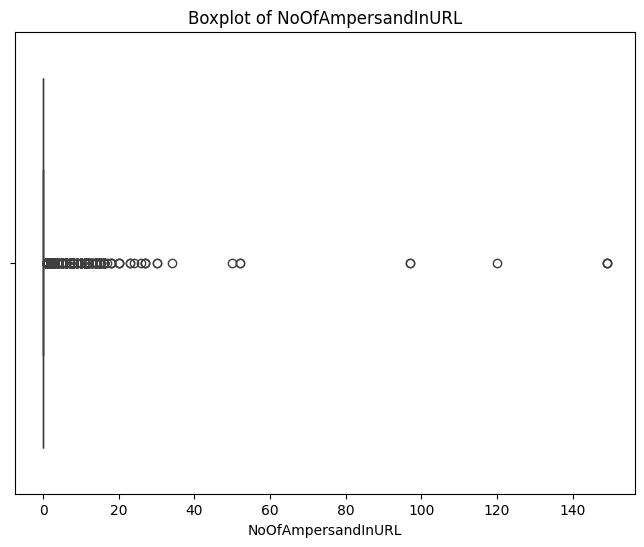

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


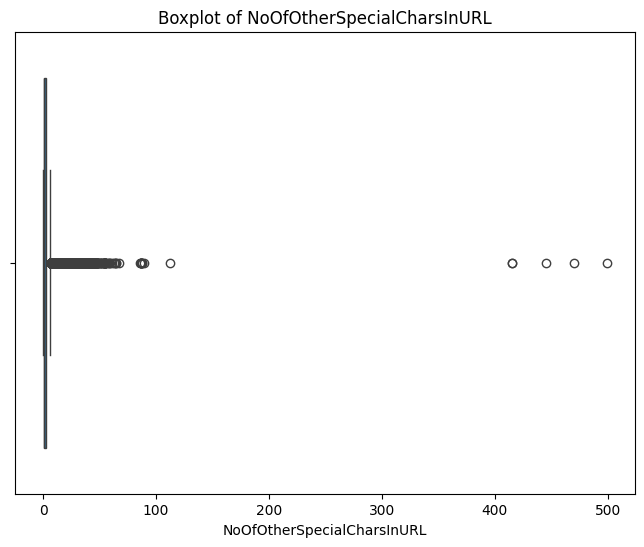

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


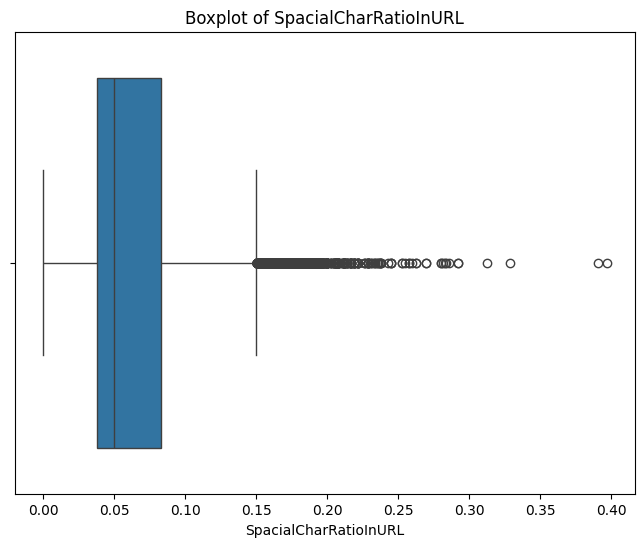

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


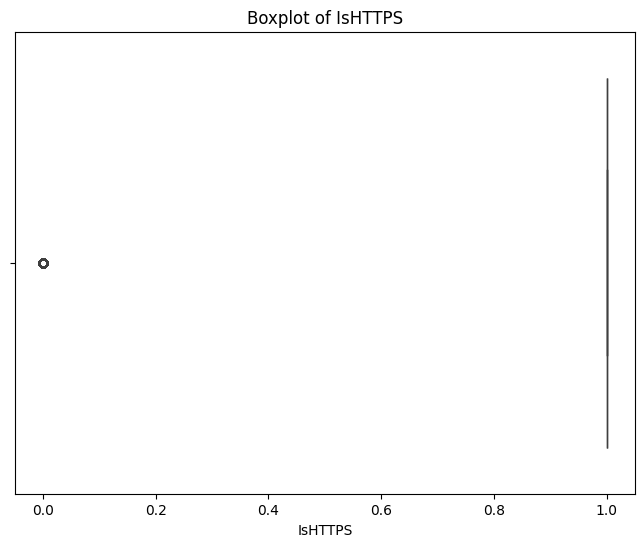

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


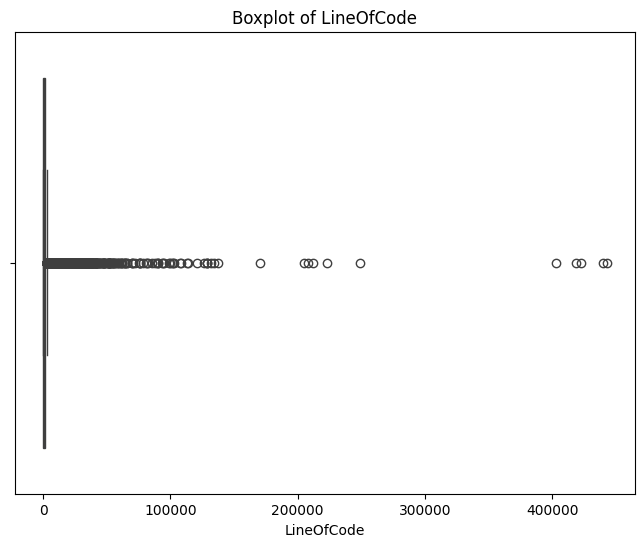

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


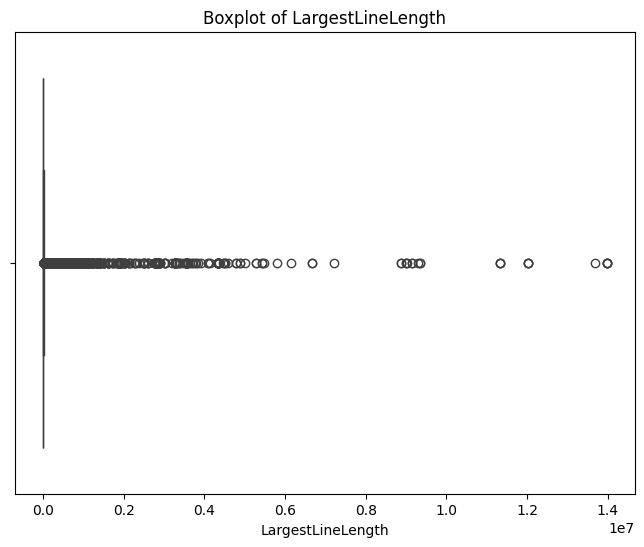

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


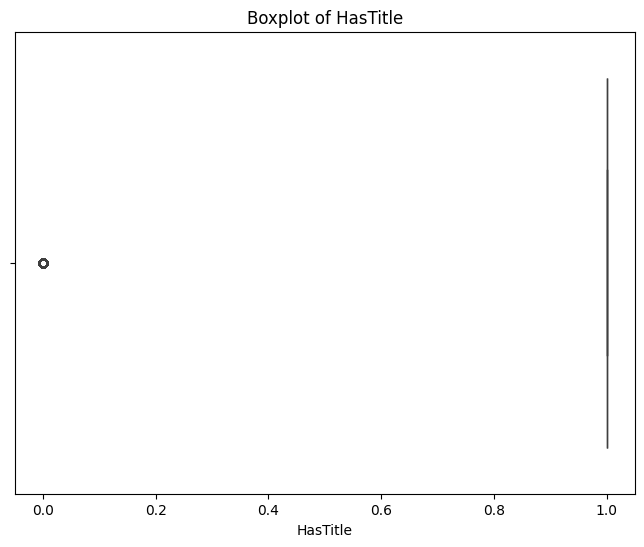

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


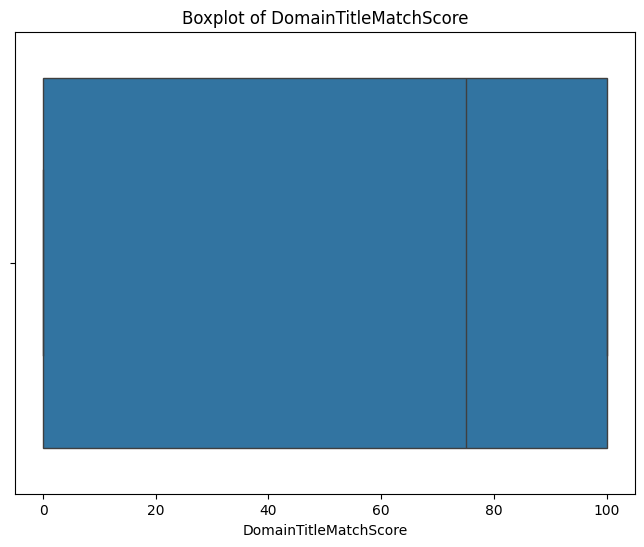

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


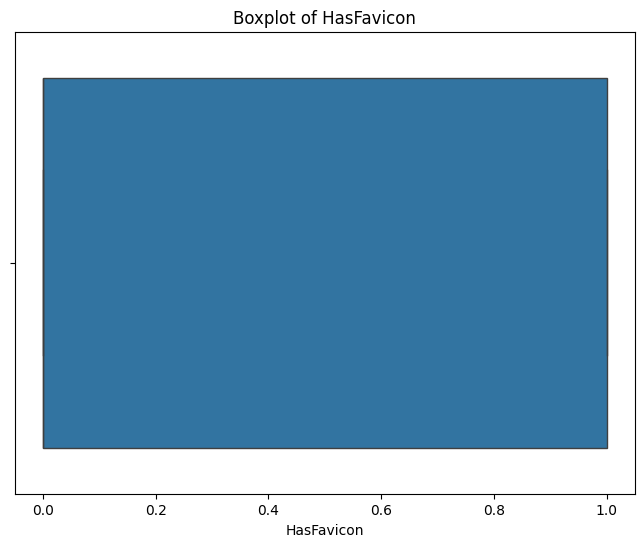

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


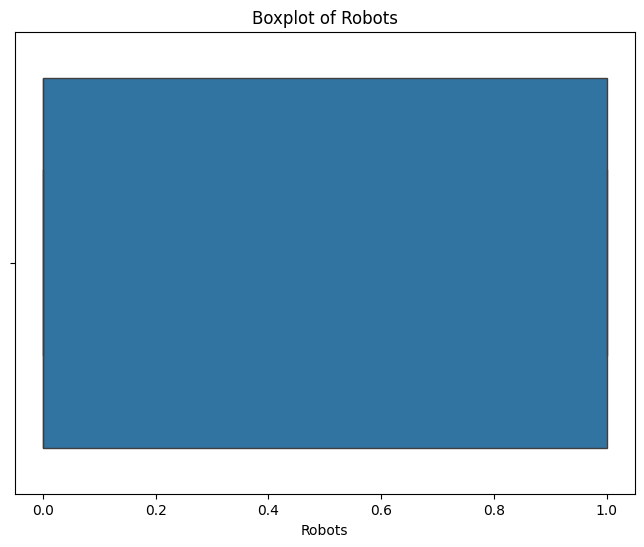

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


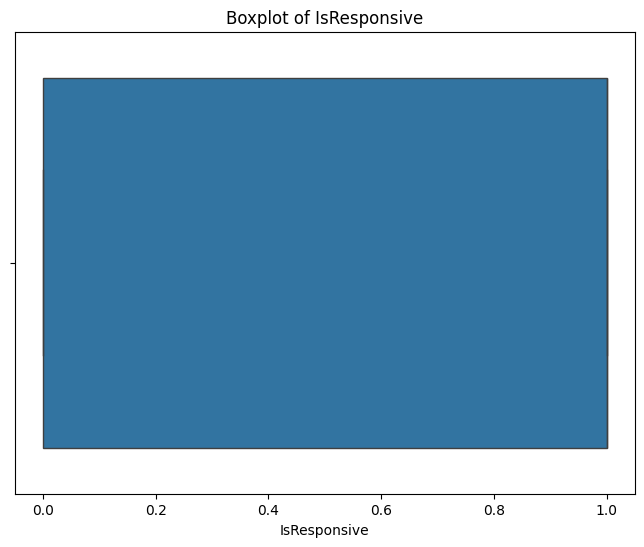

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


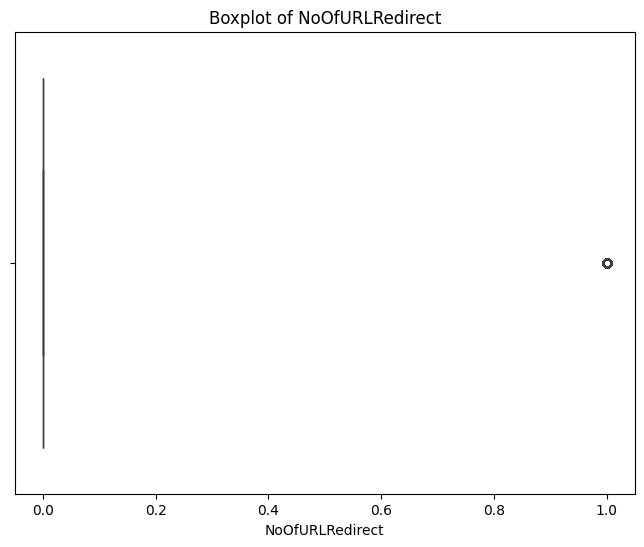

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


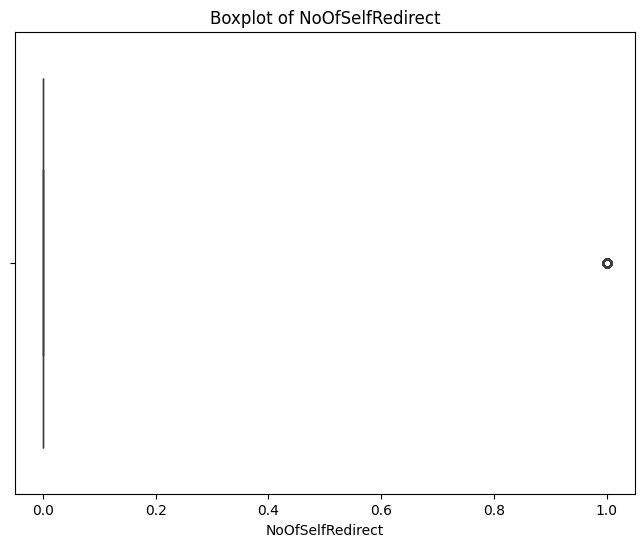

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


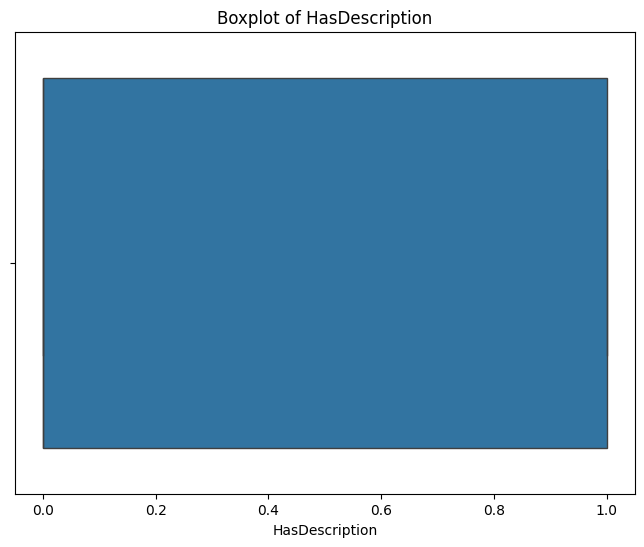

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


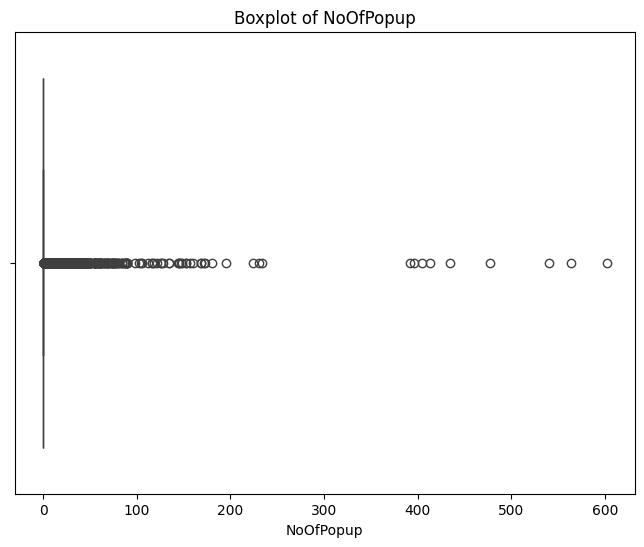

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


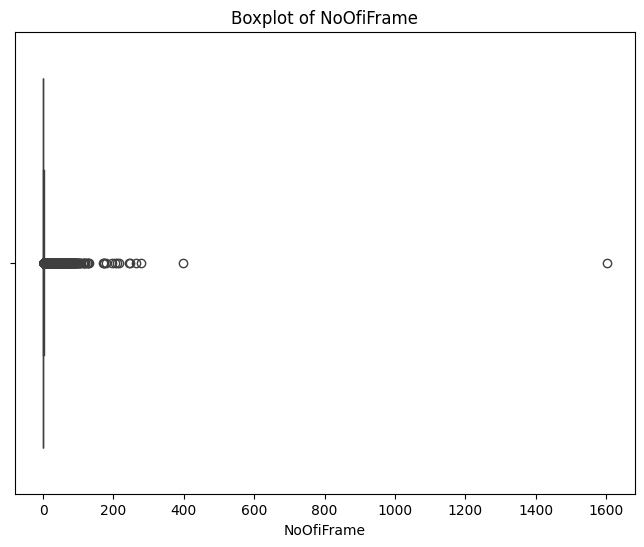

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


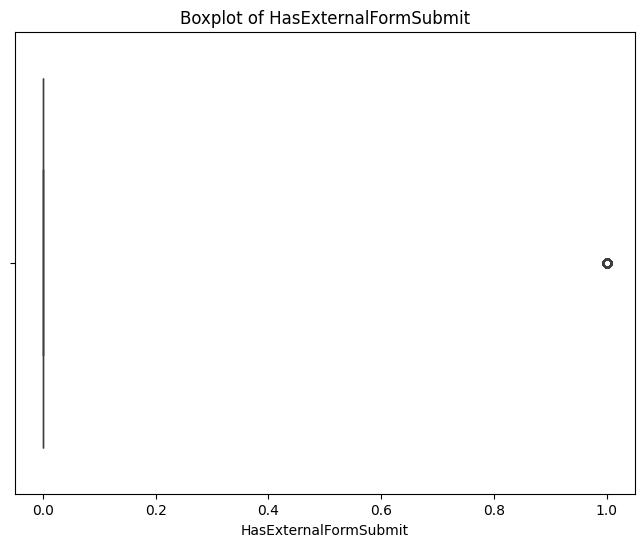

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


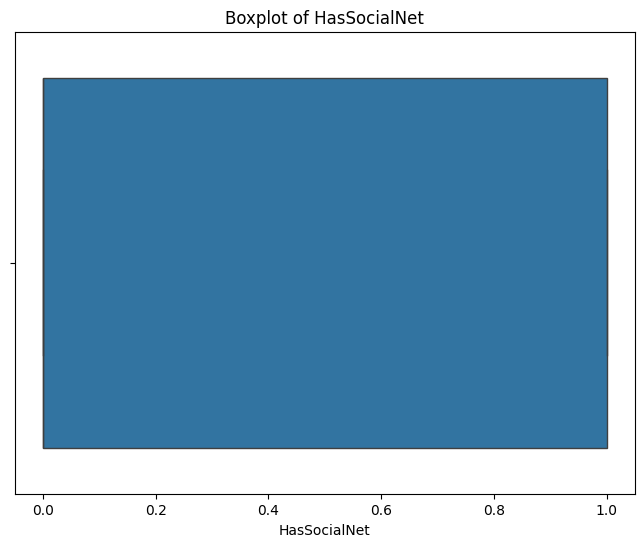

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


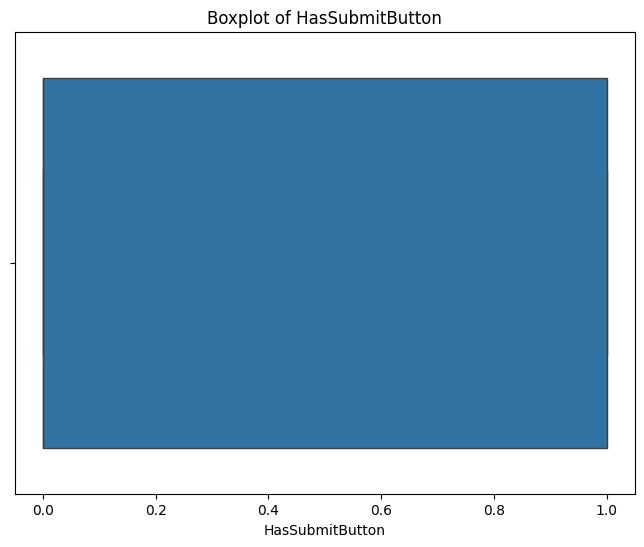

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


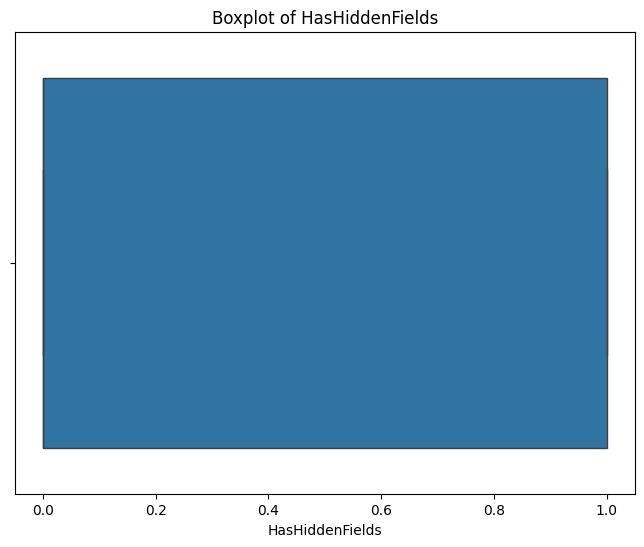

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


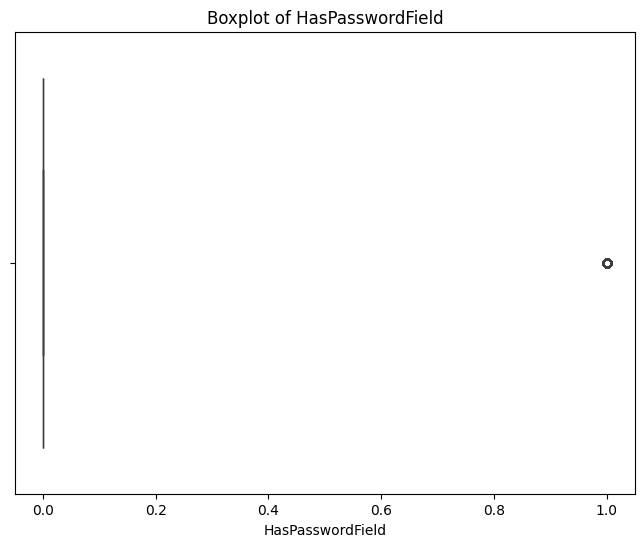

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


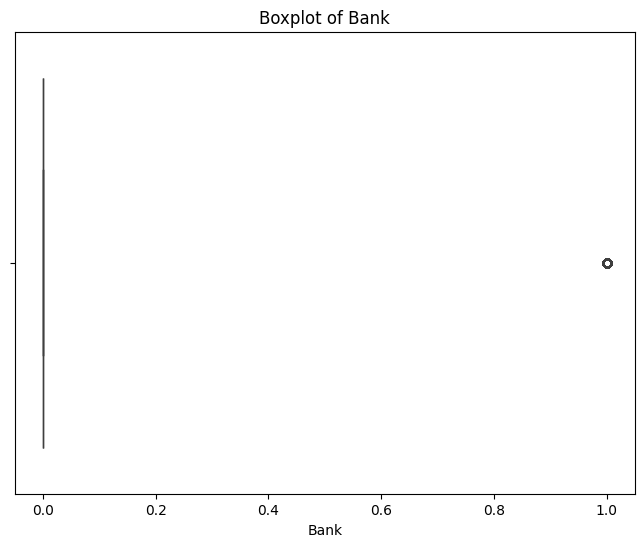

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


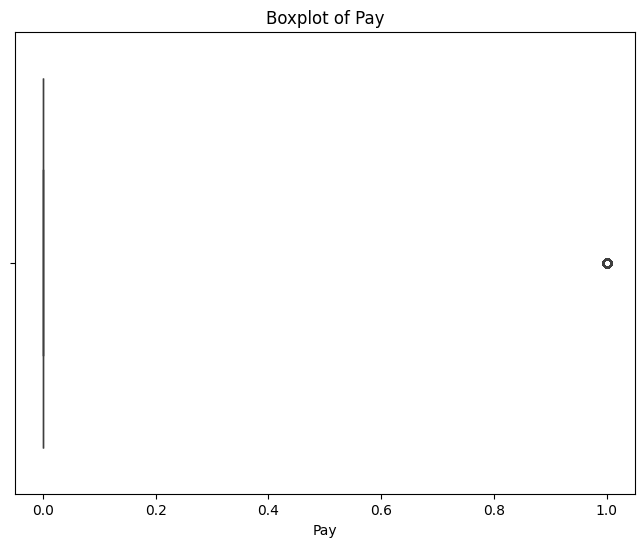

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


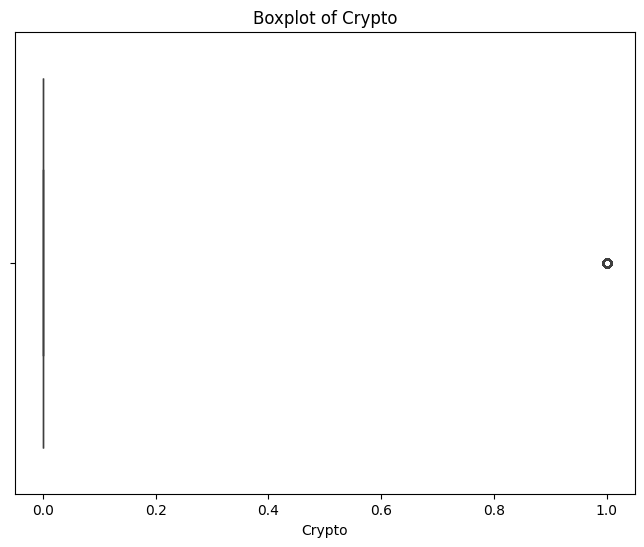

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


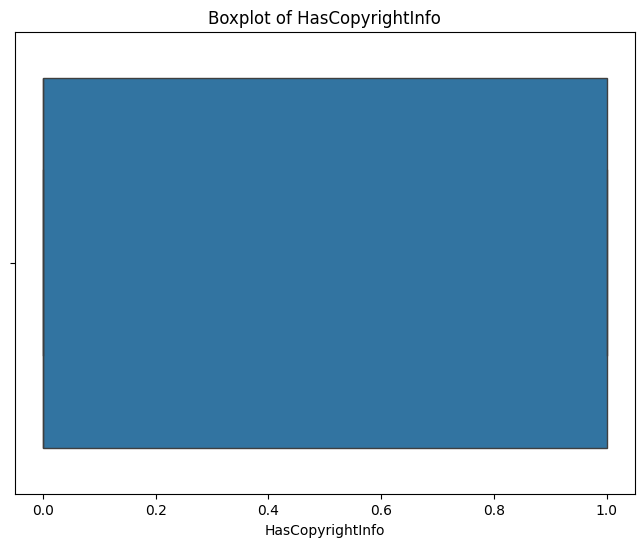

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


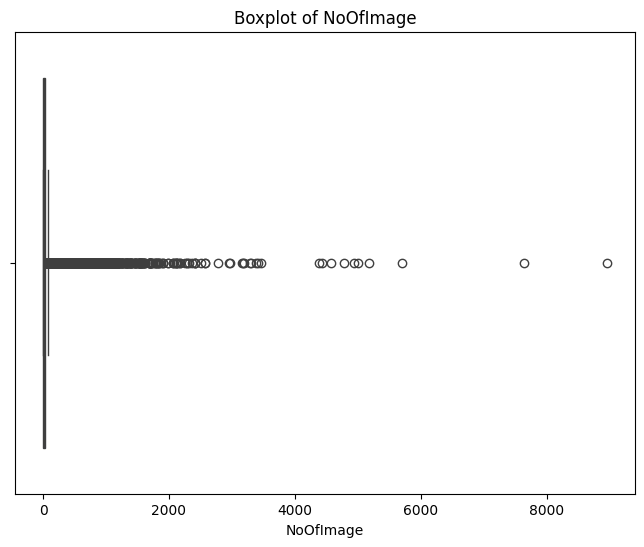

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


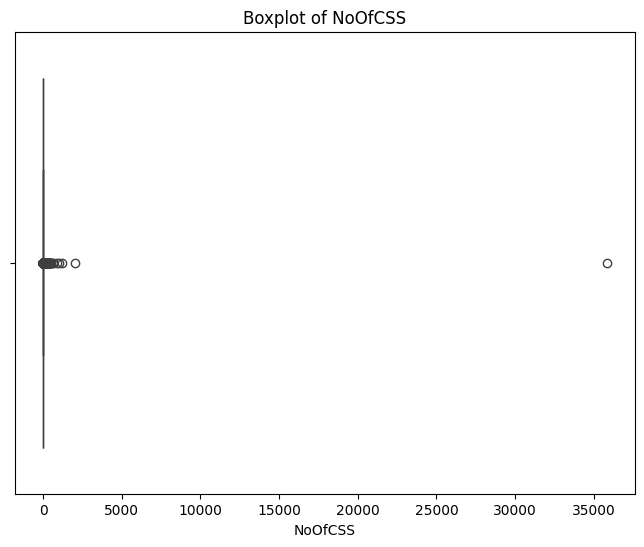

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


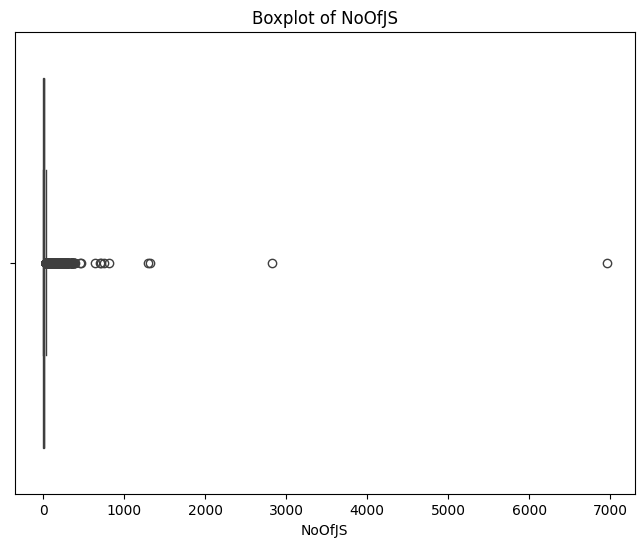

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


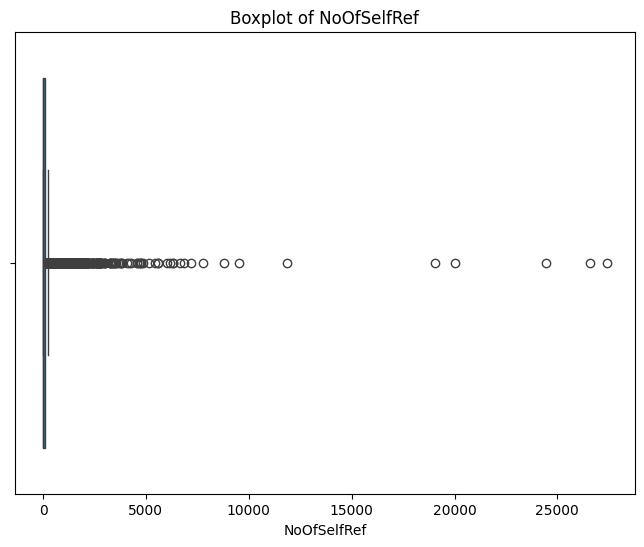

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


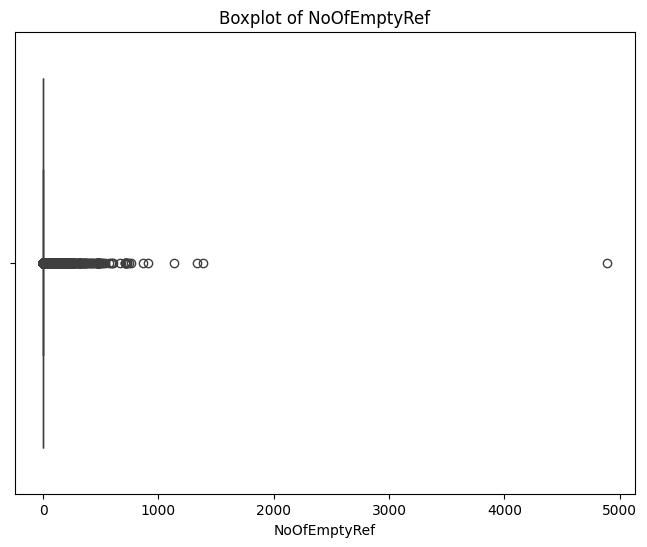

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


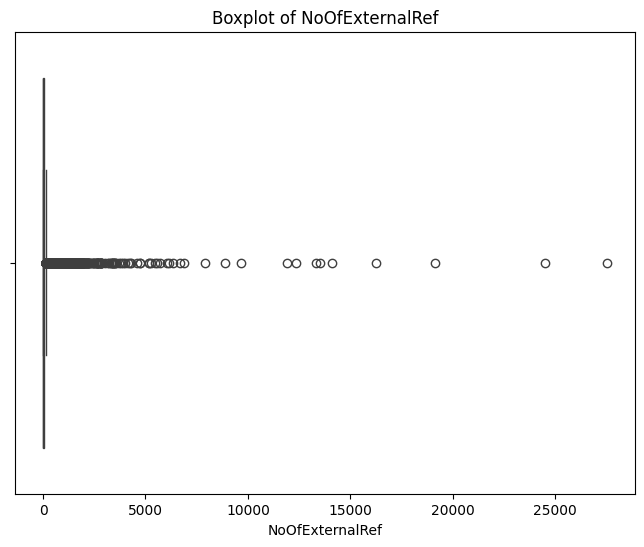

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


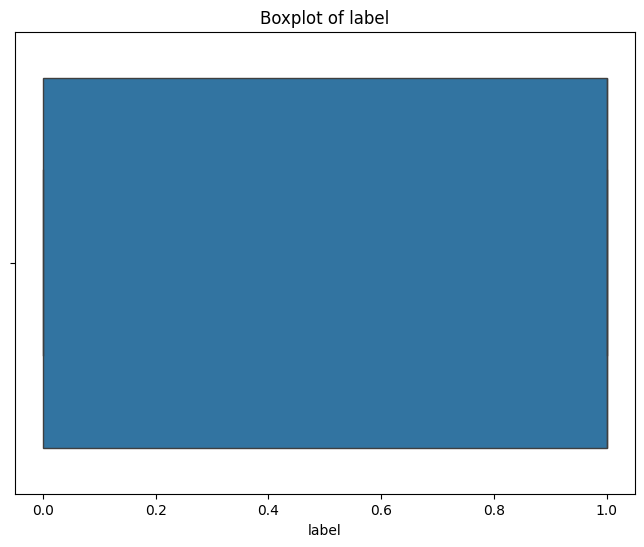

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


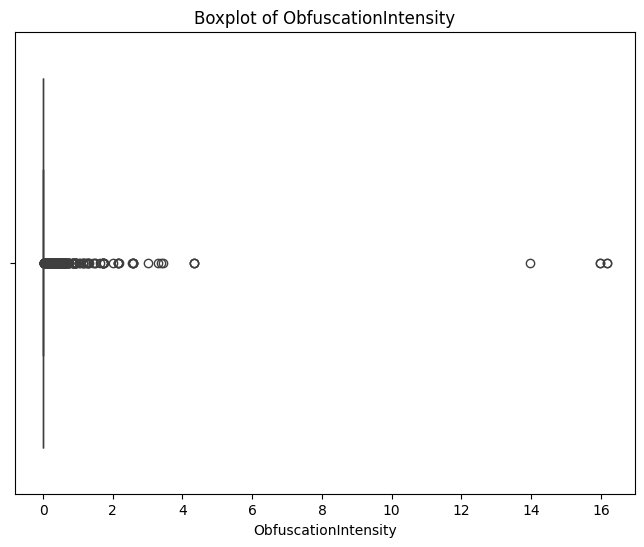

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


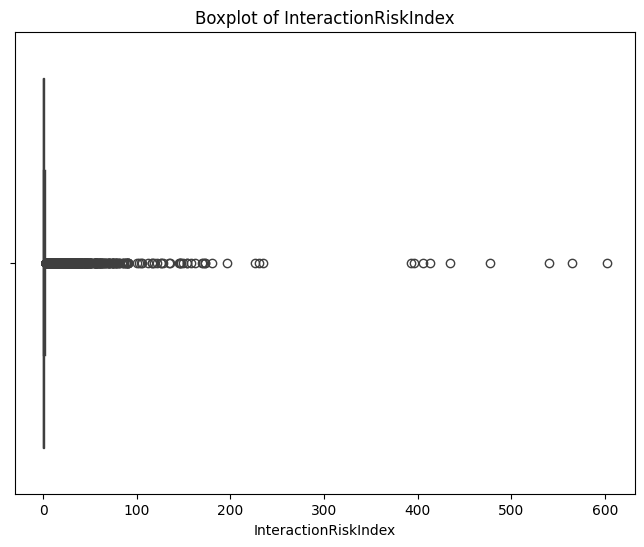

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


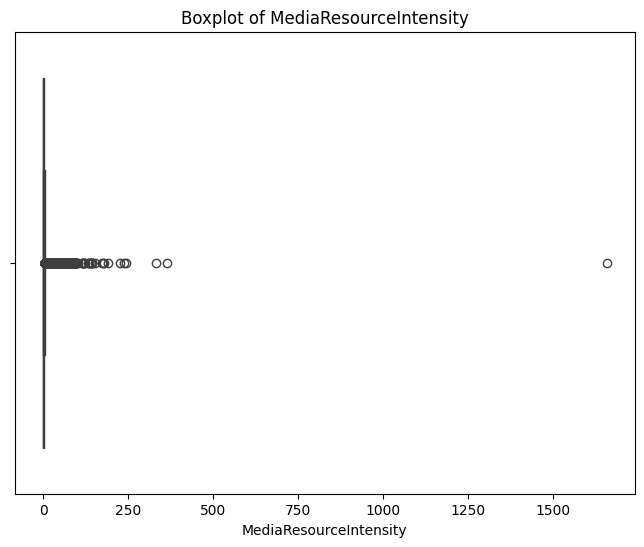

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


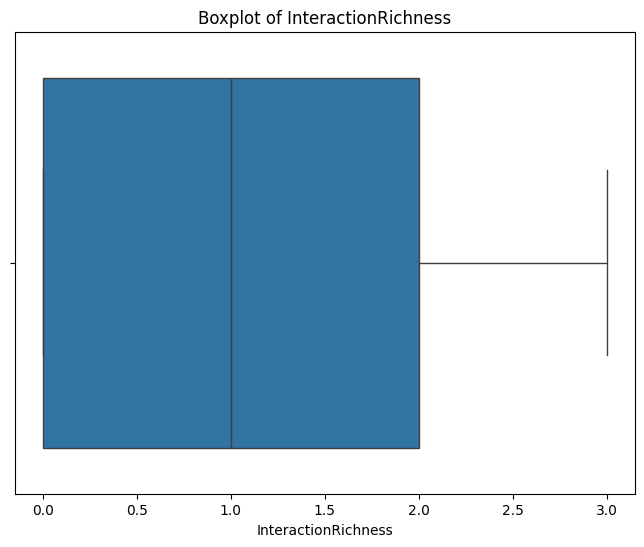

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


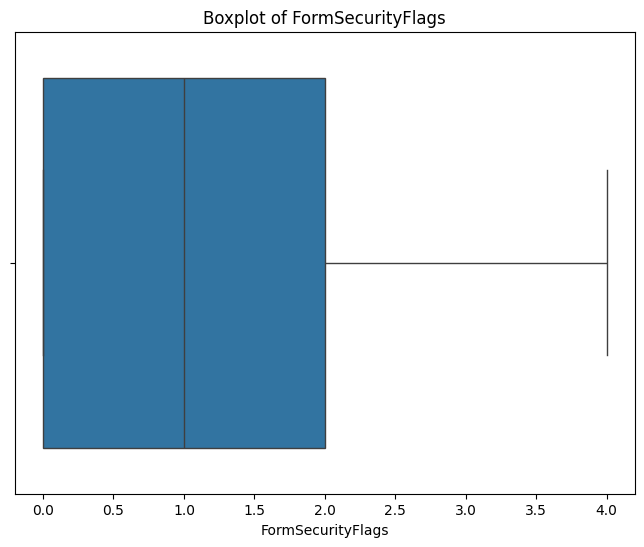

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


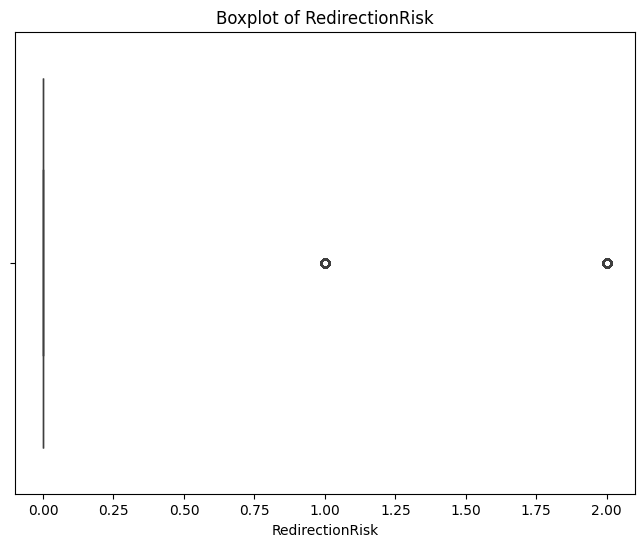

In [ ]:
draw_boxplots(train)

### Conclusion on feature analysis

First, we notice that some plot look quite odd, with square box or no box at all but points located at one or two values. That's normal. That's the case for binary or one hot value (label, bank, redirection risk, etc.)

For the other variables, we check the distribution. 
Some of them have skewed distributions. The median (line in the box) is closer to one side of the box and one whisker is longer than the other. This means that the dataset has more higher (or lower) values. 
This might be an issue for some models which are sensitive to those kind of distributions such as neural networks or linear regression. 
Therefore, we might need to do some adjustments such (transformations, feature binning or scaling)

The concerned variables are : 
- MediaResourceIntensity 
- InteractionRiskIndex 
- LineOfCode 
- ObfuscationIntensity
- NoOfExternalRef
- SpacialCharRatioInURL
- NoOfOtherSpecialCharsInURL
- NoOfAmpersandInURL
- NoOfEqualsInURL
- NoOfDegitsInURL
- NoOfLettersInURL
- NoOfObfuscatedChar
- URLLength
- NoOfPopup
- NoOfiFrame
- NoOfImage
- NoOfCSS
- NoOfJS
- NoOfSelfRef
- NoOfEmptyRef

Another issue would be the outliers, id est the points outside the whiskers. 
They either mean a natural variability or an anomaly. If they are frequent or extreme, it means we have to do a bit of cleaning in the dataset by removing, capping or transforming them. 

The concerned variables are : 
- DomainTitleMatchScore
- SpacialCharRatioInURL

It's also important to notice that the range of distribution among the features is different : we must scale the data before training our future model, especially the ones based on distance (KNN, Logistic Regression, ... but not Decision Tree for example, it is not necessary).

# Histograms 

Still, to see the distribution of each numerical variables, we can use histograms.

In [36]:
""" TIPS 
bins := ranges into which data values are grouped 

50-100 bins = an overview with some detail
400-500 bins = a more granular view, particularly useful if the data has many unique values or a complex distribution
around 100 bins = a balance, providing enough detail for most exploratory data analyses on large datasets without overwhelming the visualization
"""

def draw_histograms(df, bins=100):
    
    for column in df.columns:
        if ptypes.is_numeric_dtype(df[column]):
            plt.figure(figsize=(8, 6))
            sns.histplot(df[column], bins=bins, kde=True)
            plt.title(f'Histogram of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.show()

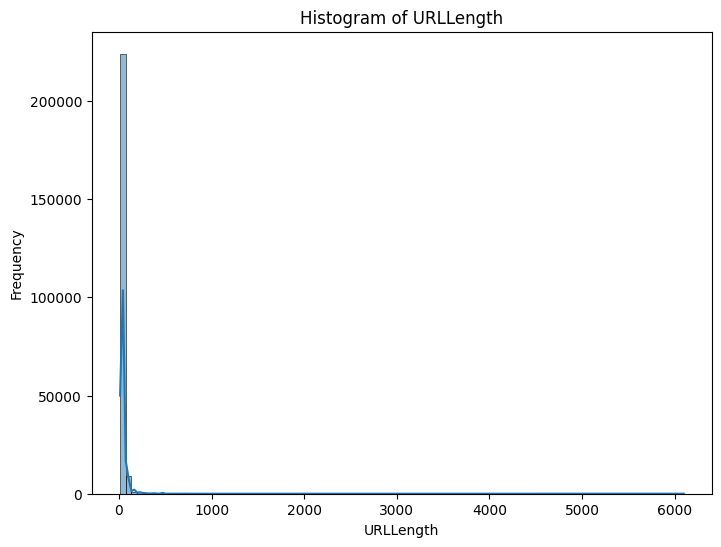

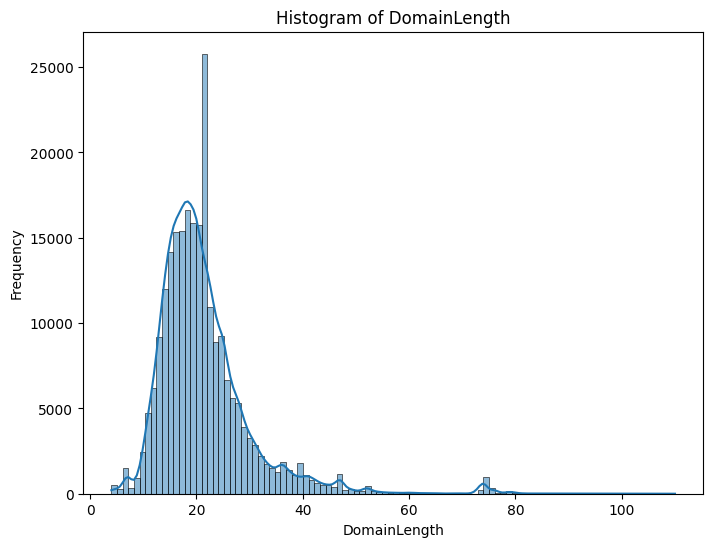

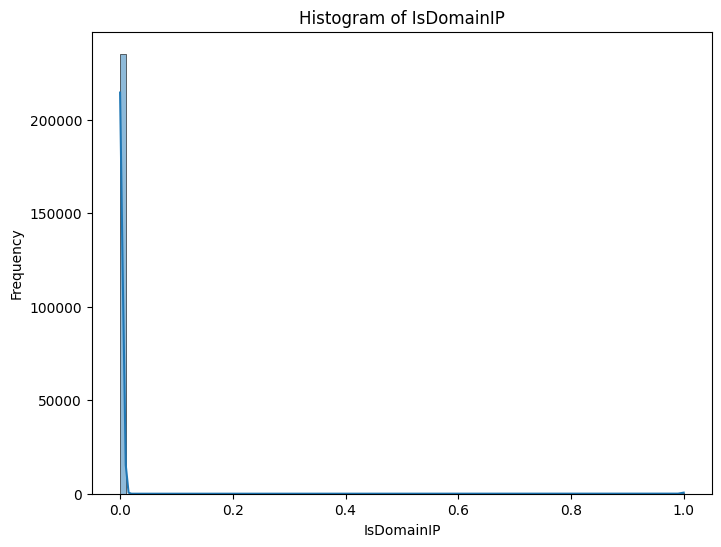

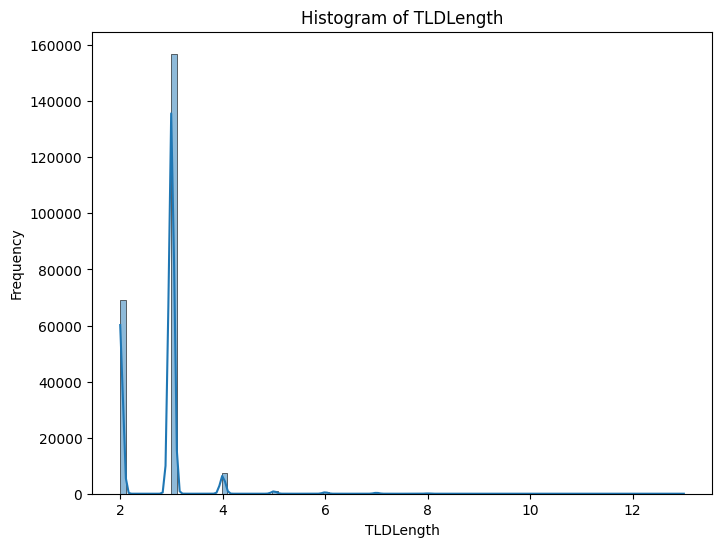

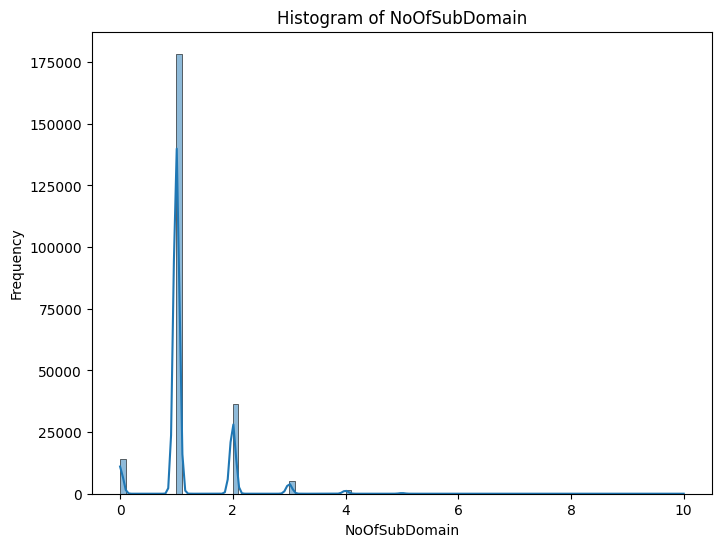

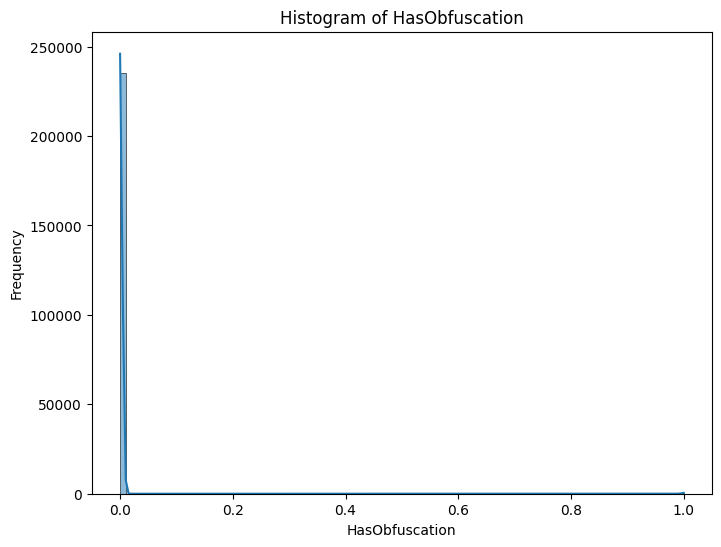

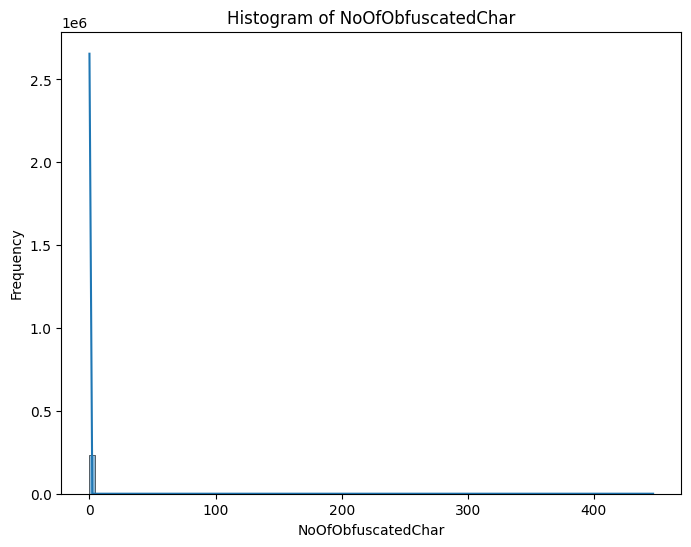

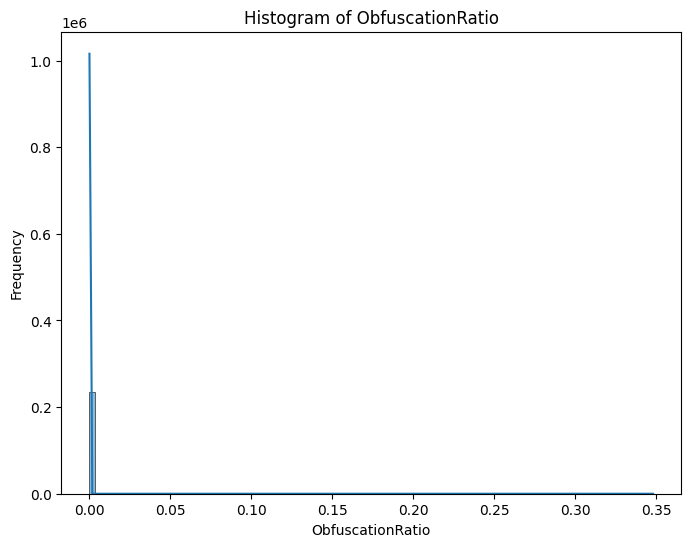

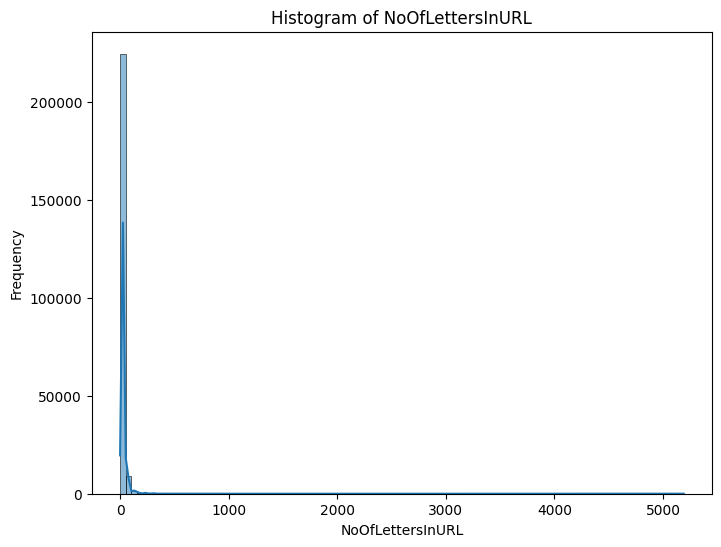

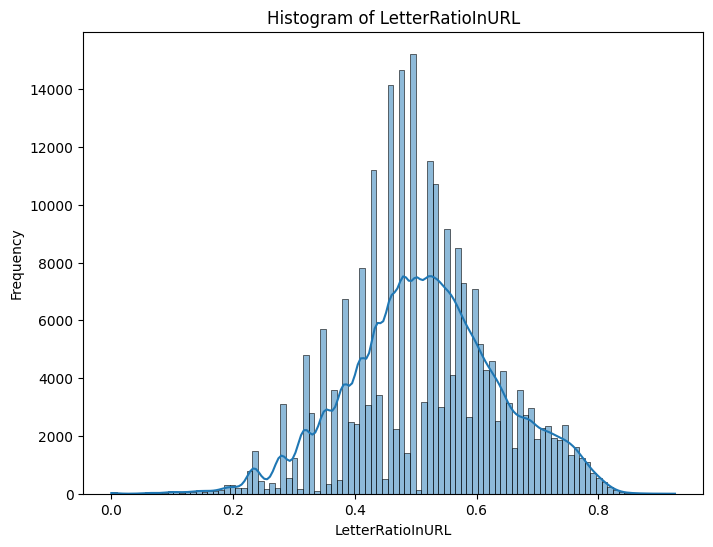

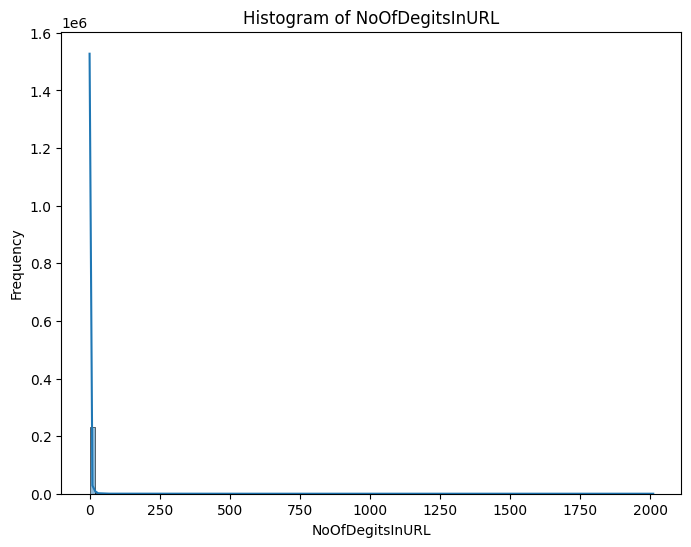

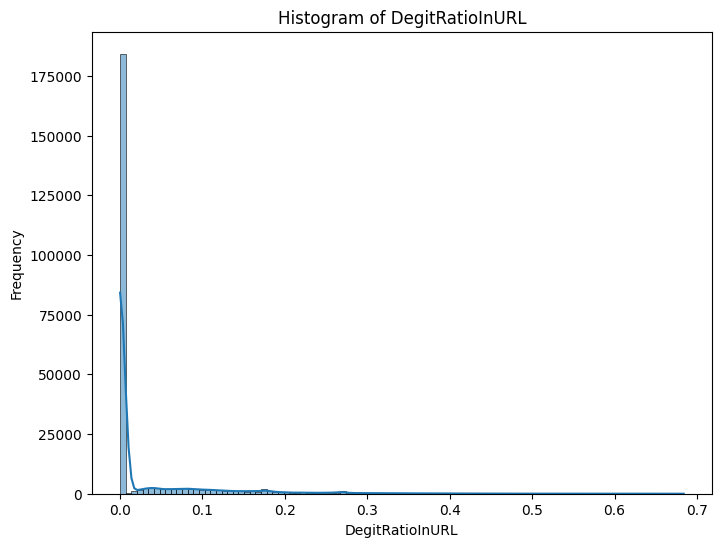

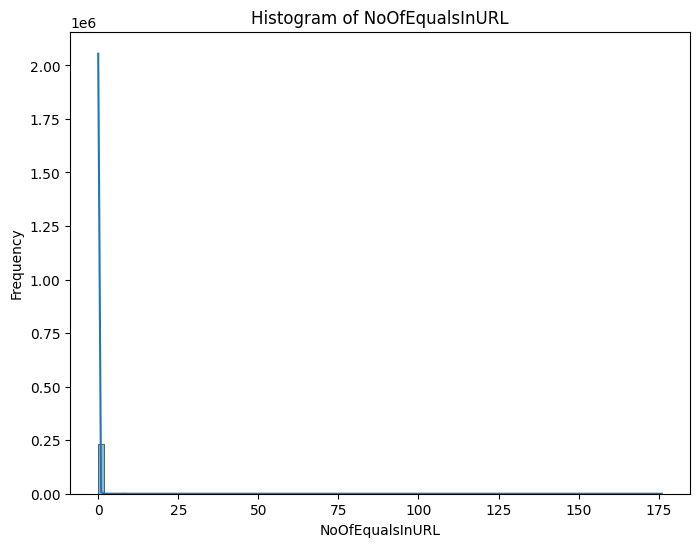

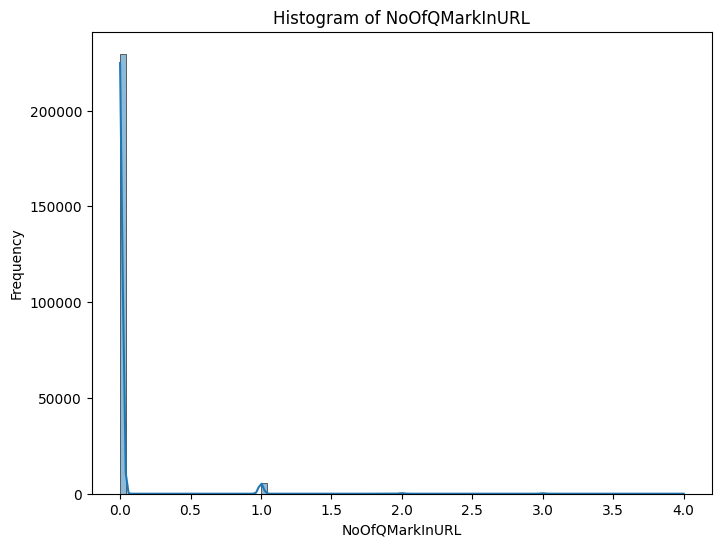

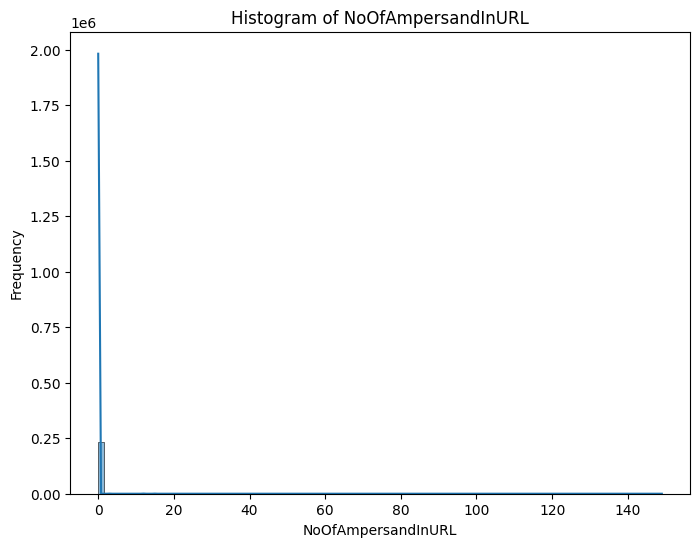

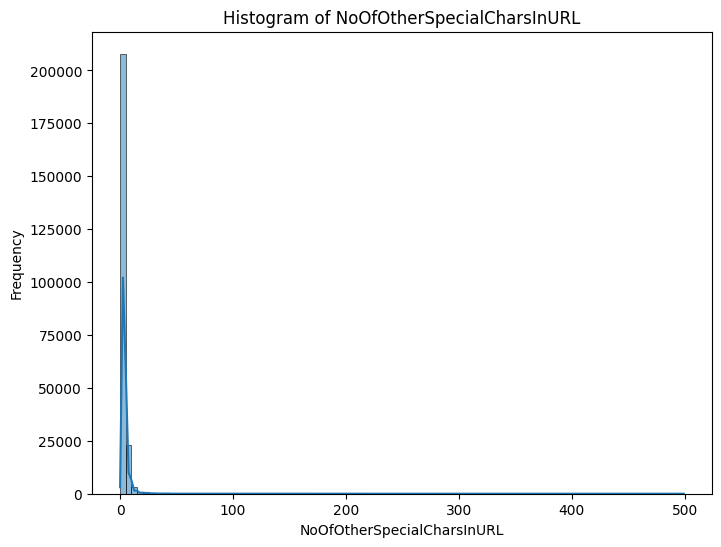

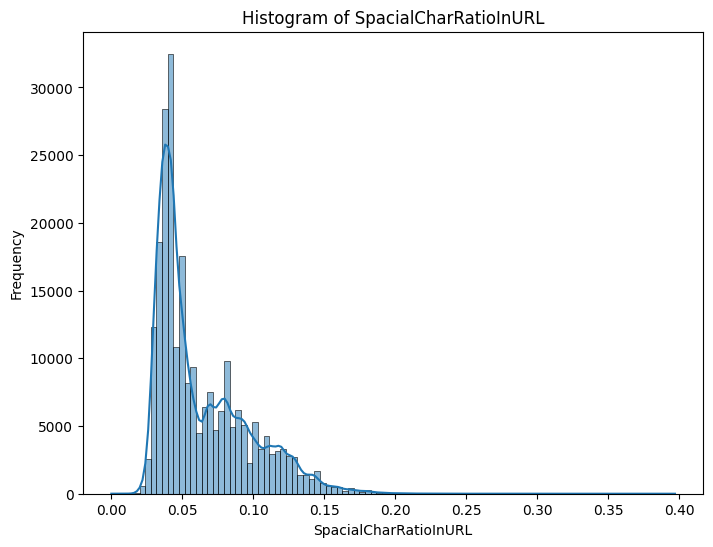

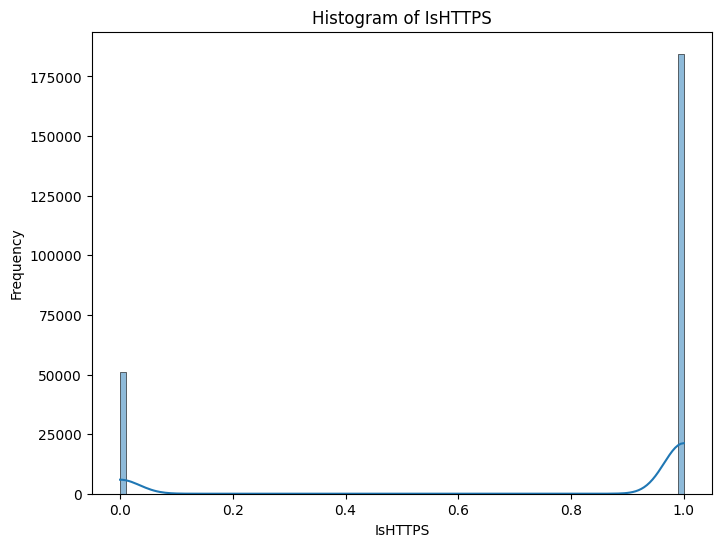

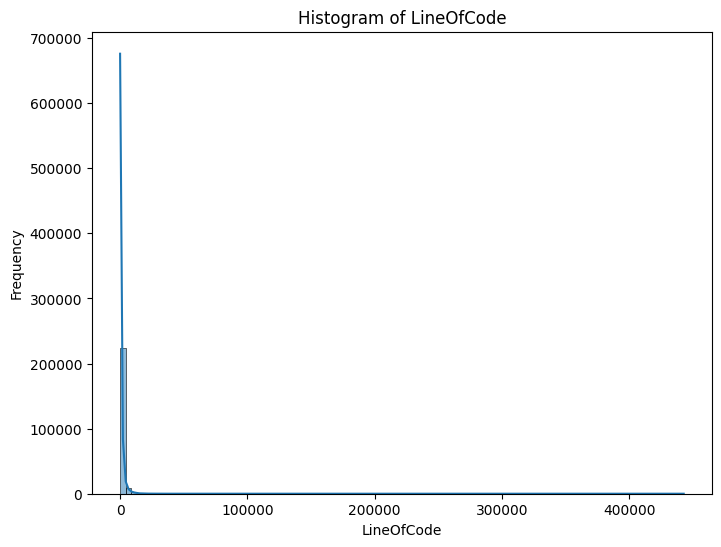

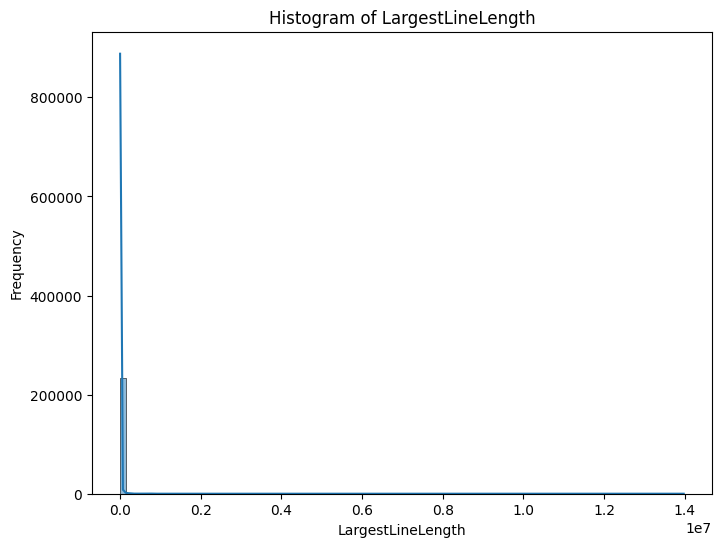

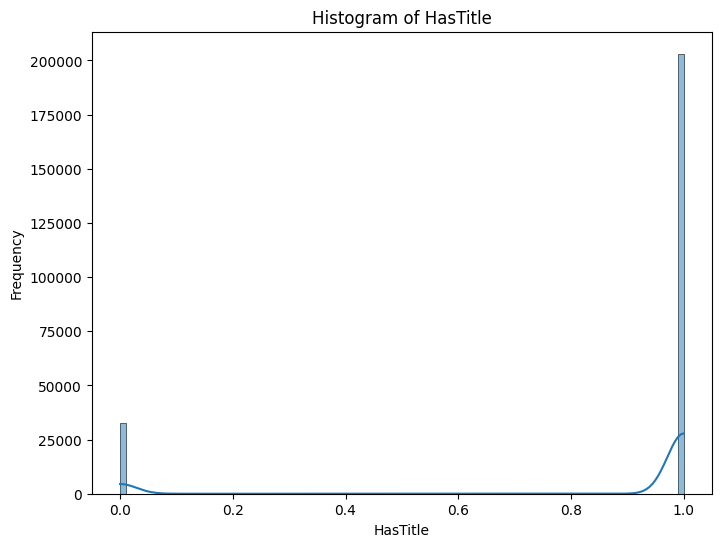

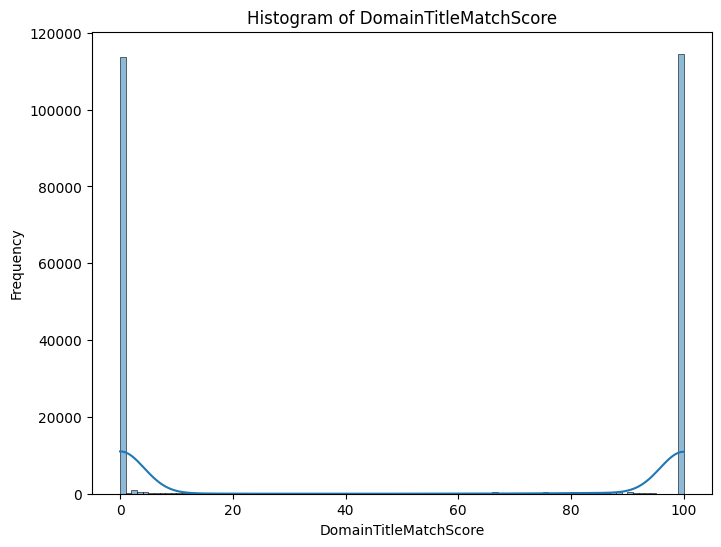

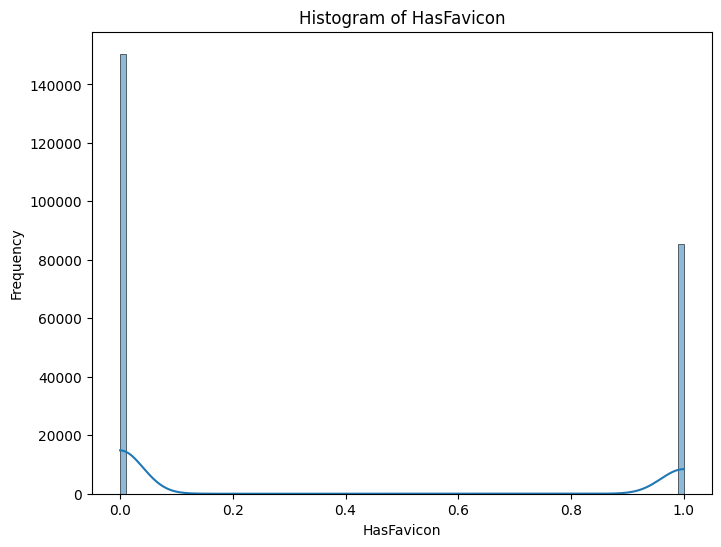

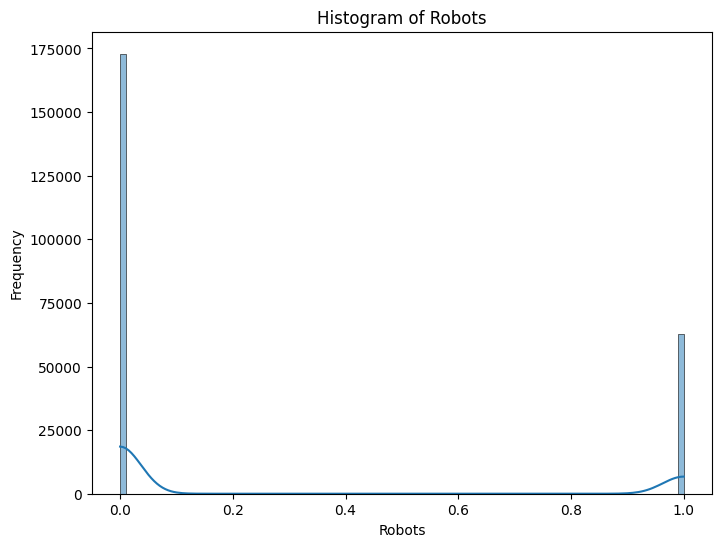

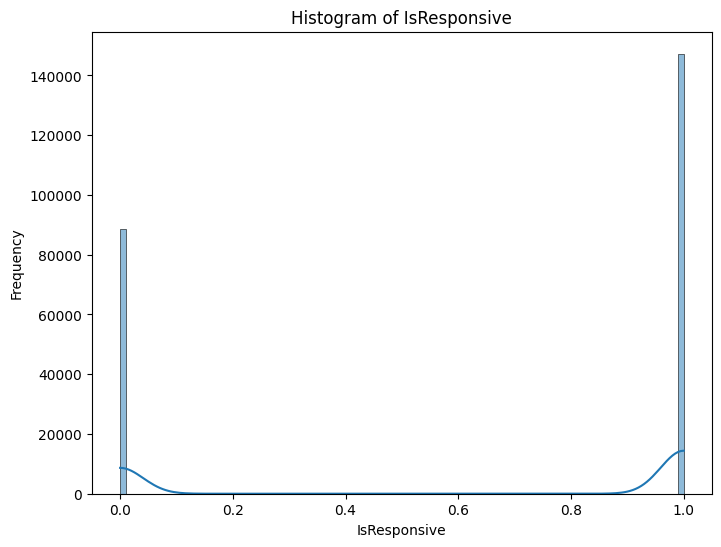

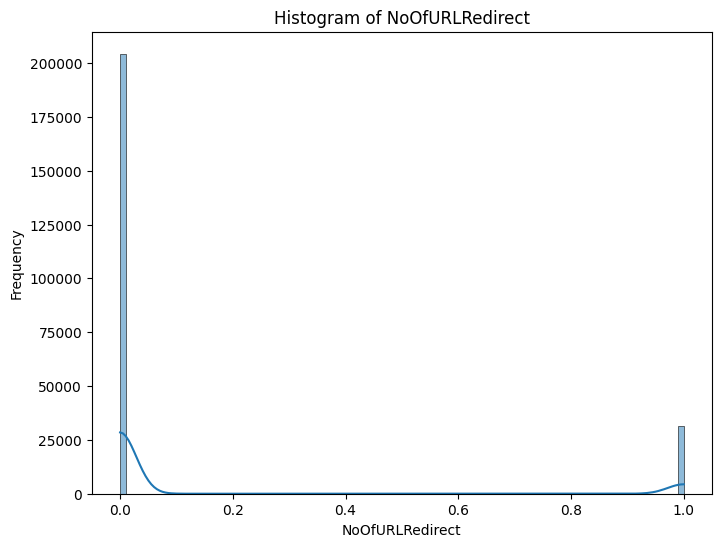

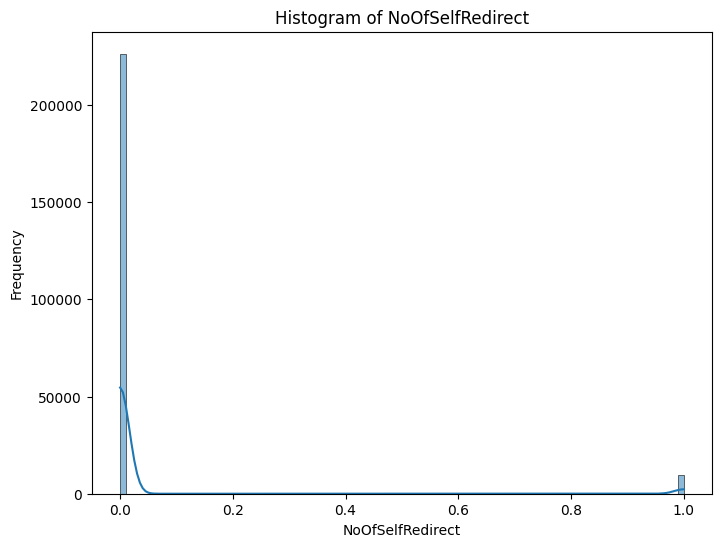

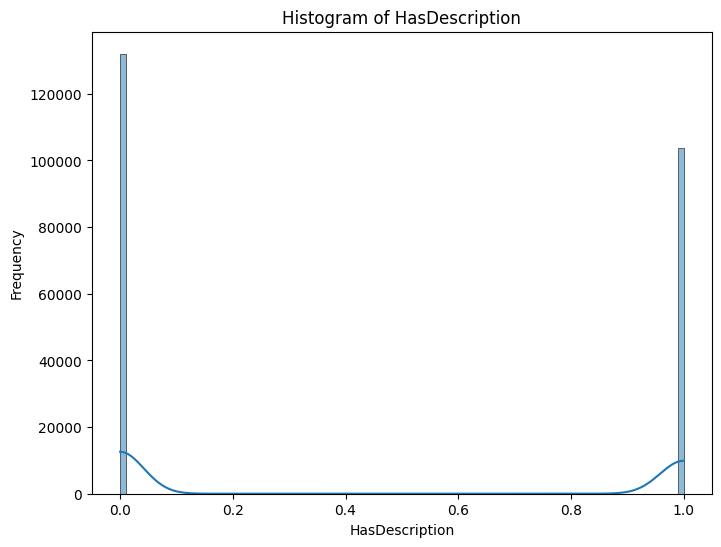

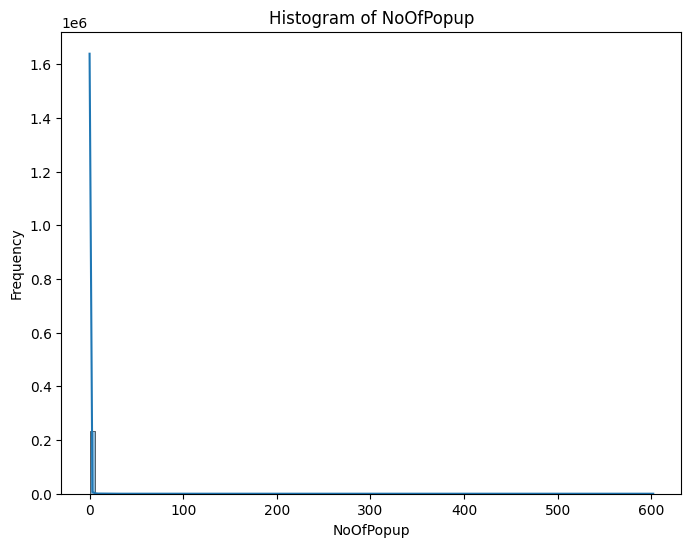

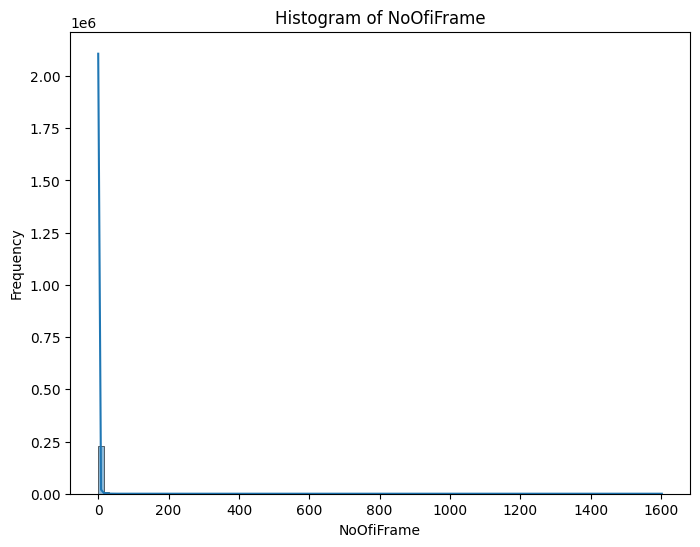

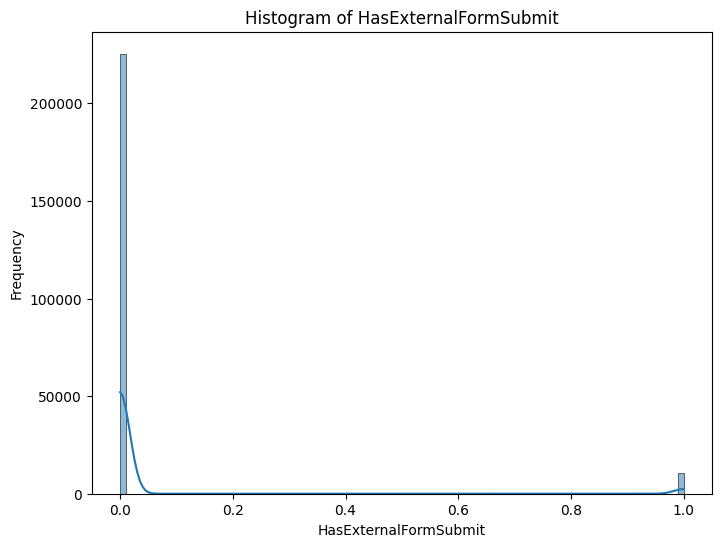

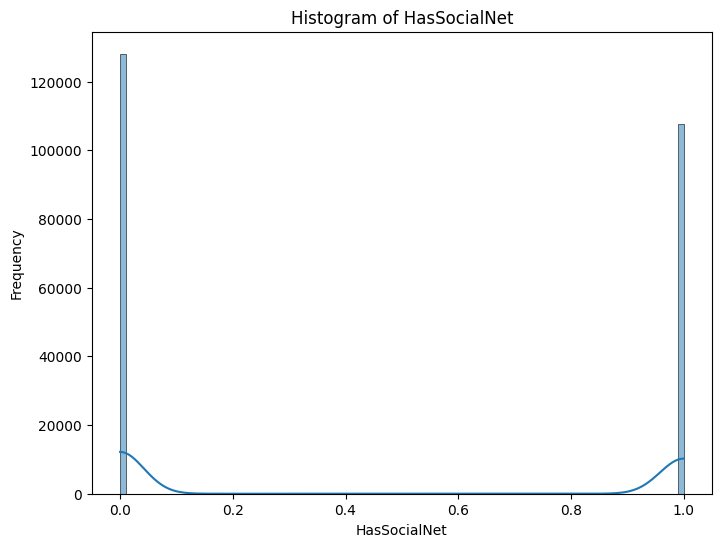

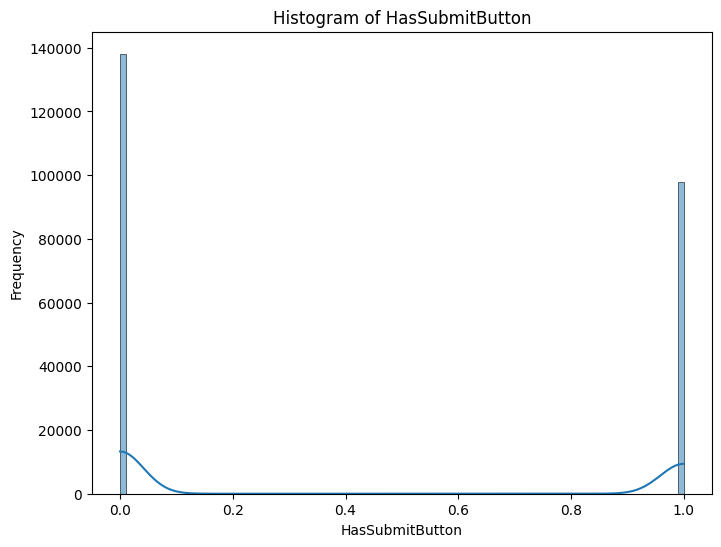

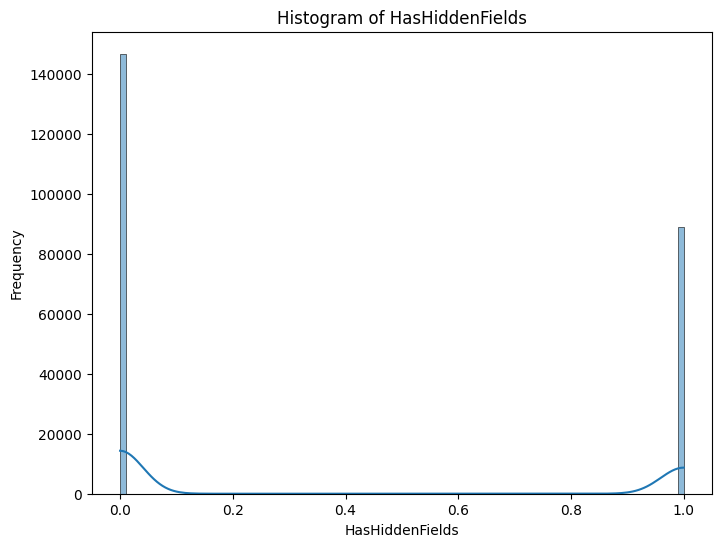

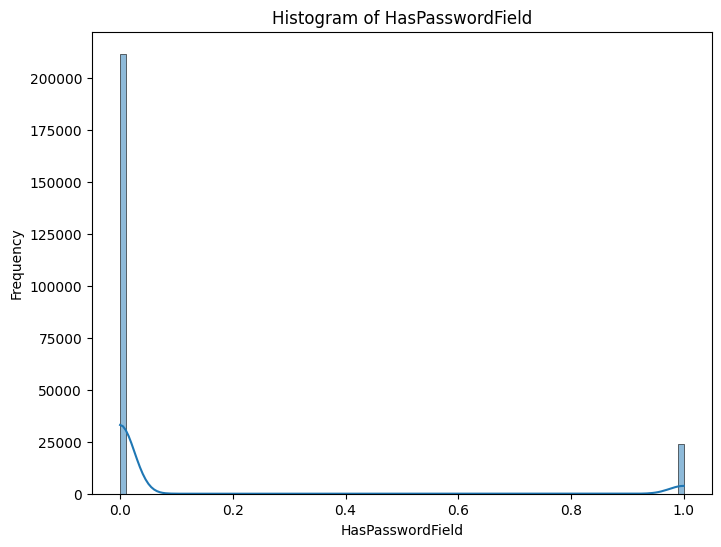

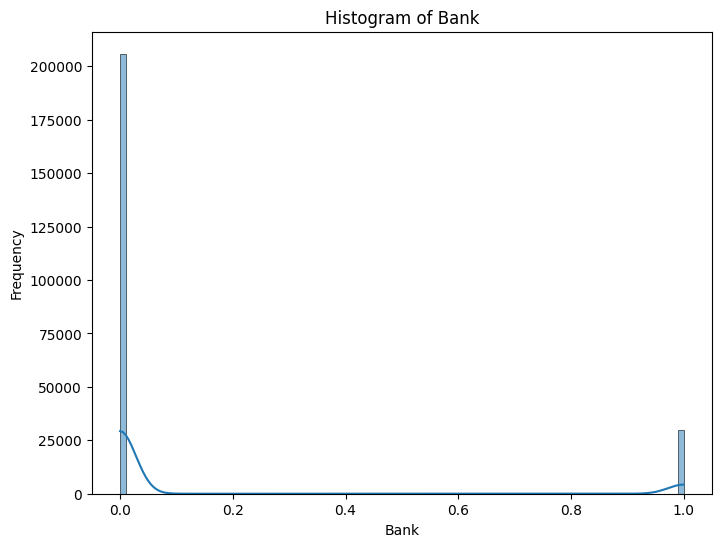

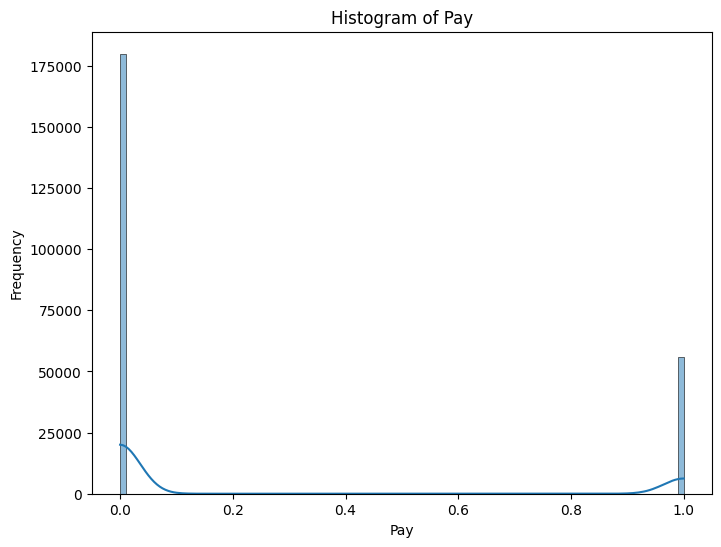

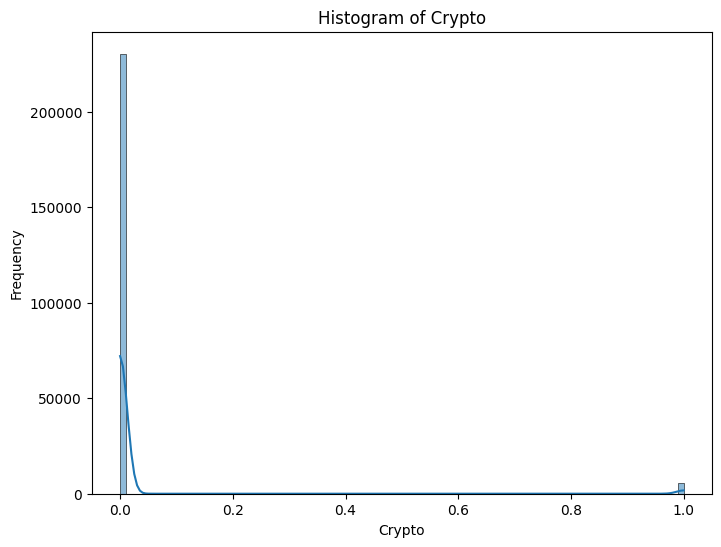

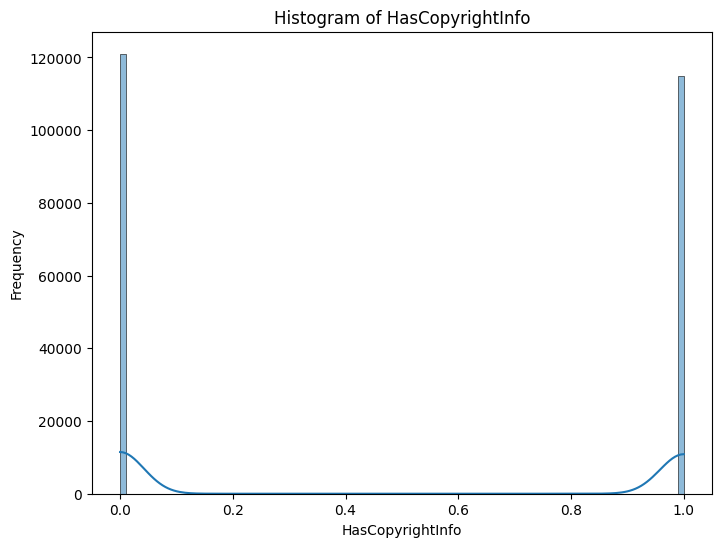

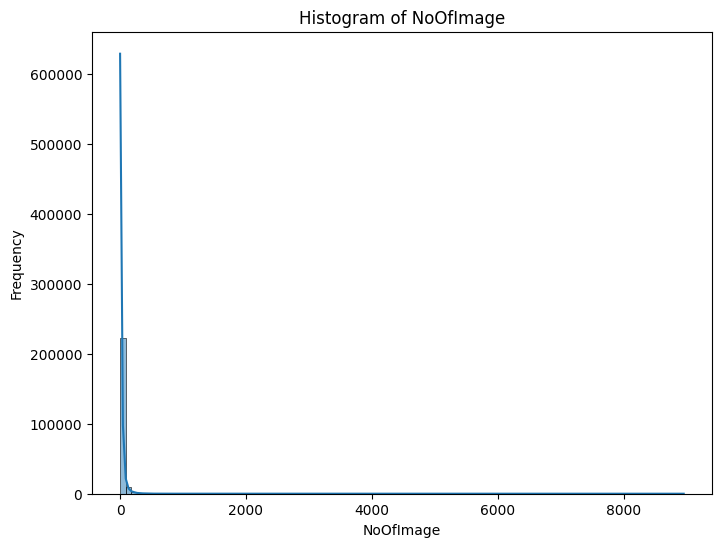

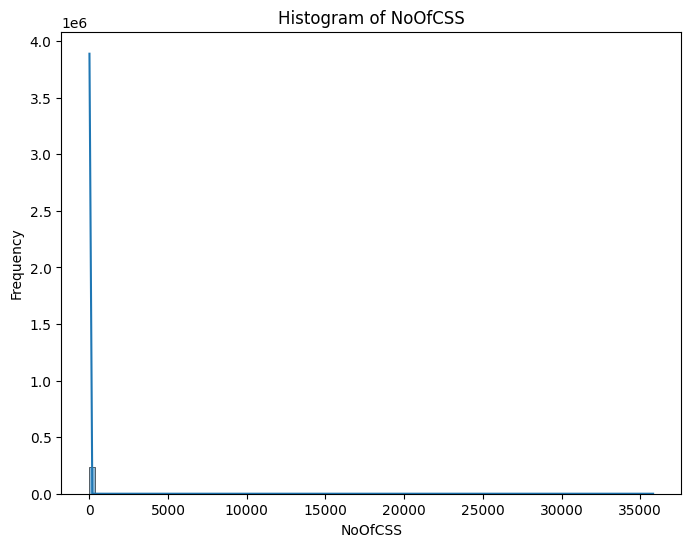

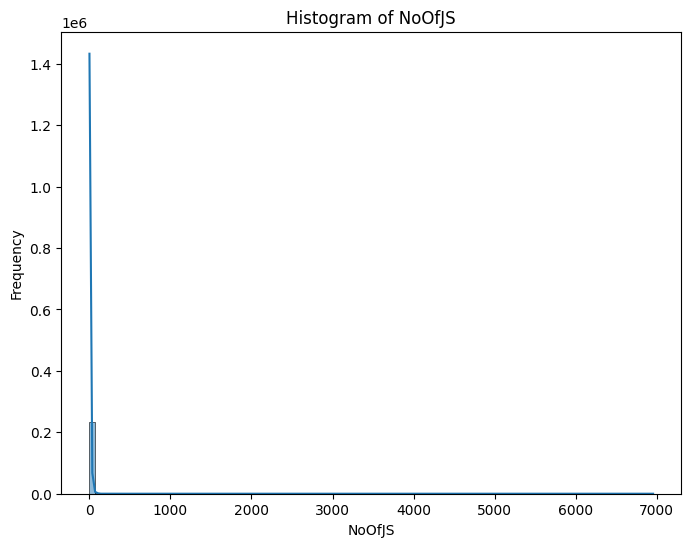

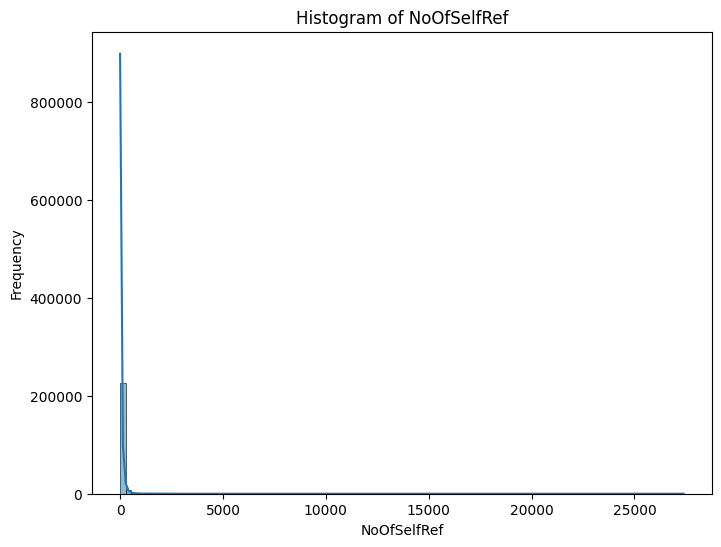

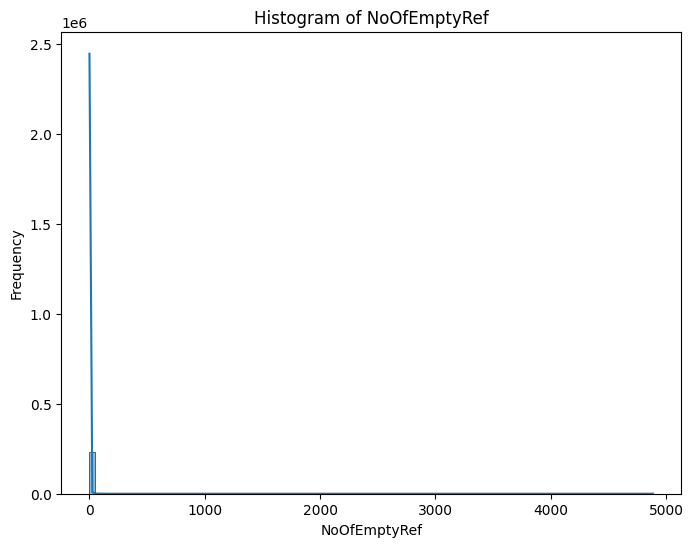

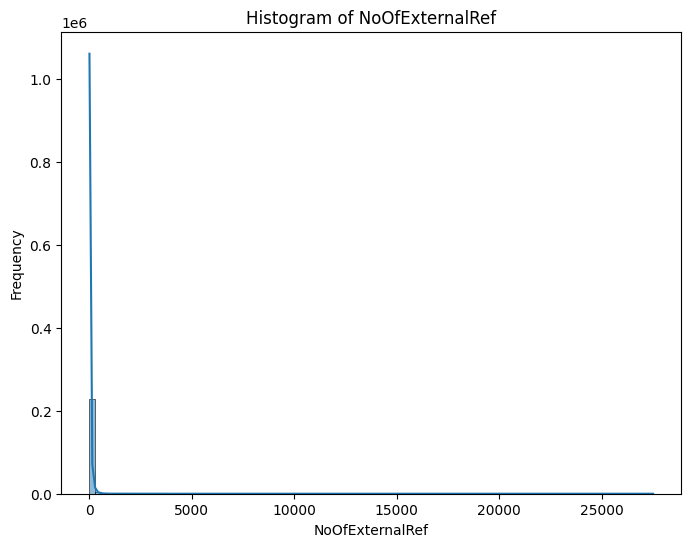

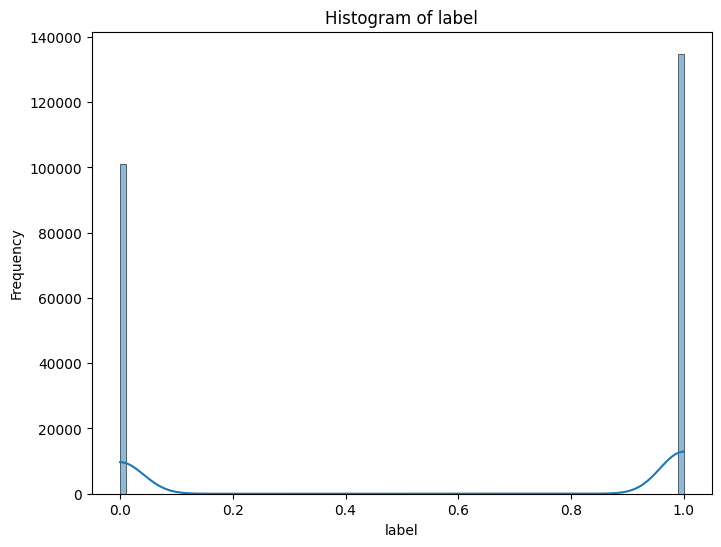

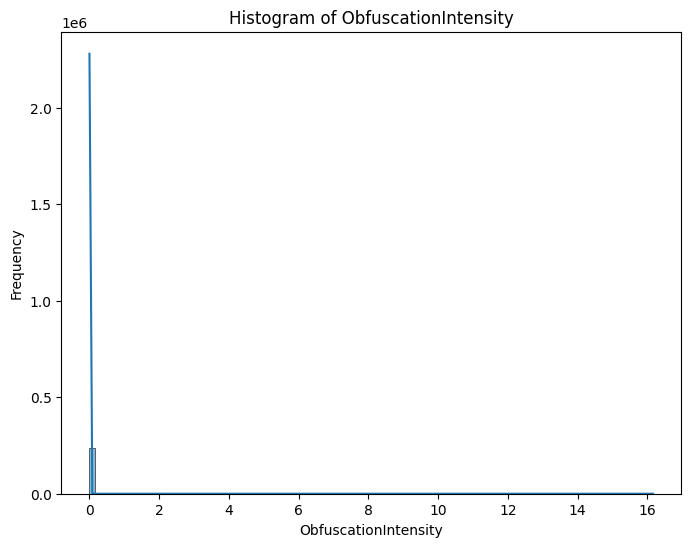

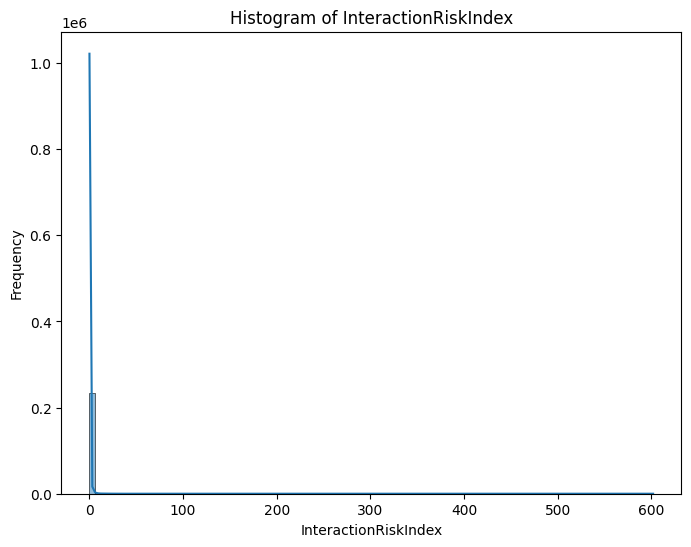

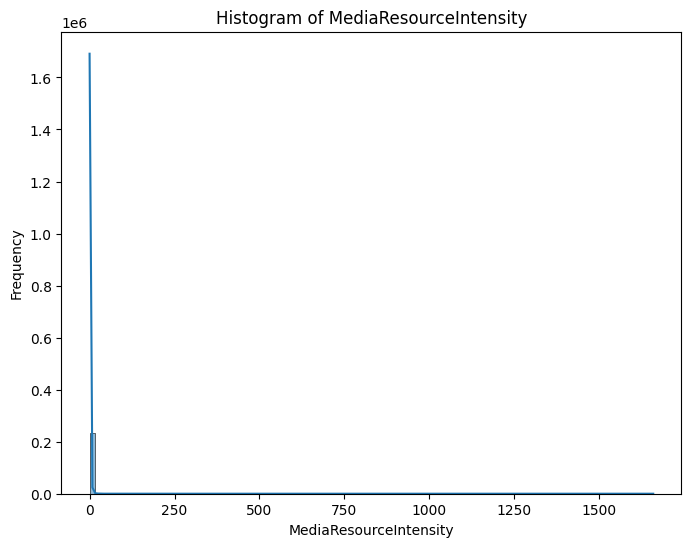

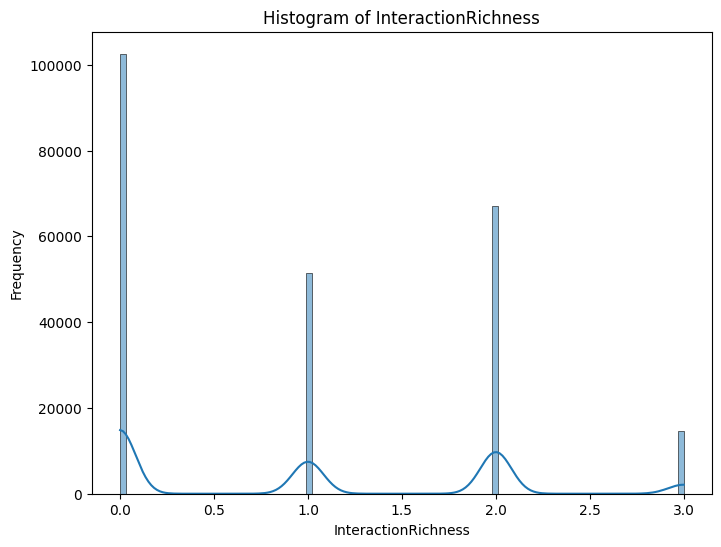

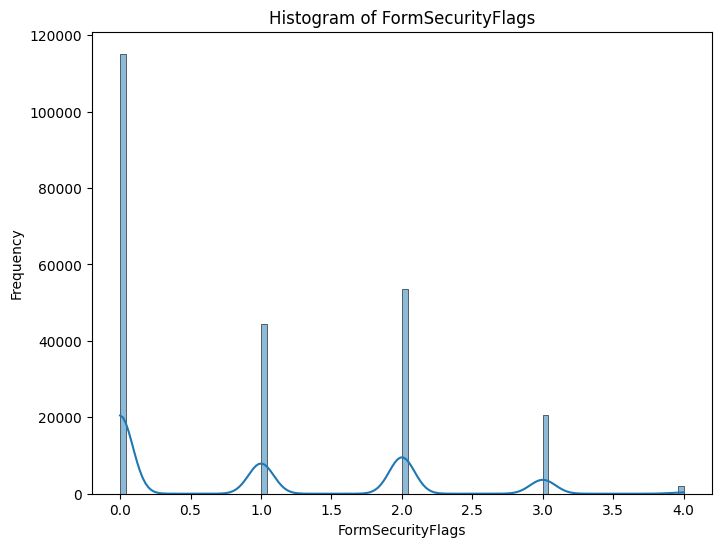

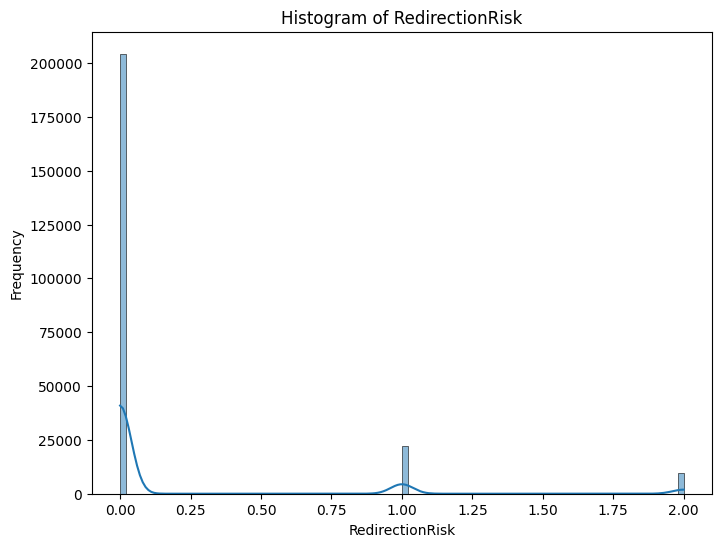

In [ ]:
draw_histograms(train)

### Conclusion on feature engineering 

Histograms reveal the underlying distribution of data. 
Skewness in an histogram is synonym with abnormal distribution. 
The concerned variables are : 
- SpacialCharRatioInURL
- NoOfOtherSpecialCharsInURL
- NoOfLettersInURL

### Categorical variables analysis : Chi-Square test 
The Chi-Square test is used to determine whether there is a significant association between to categorical variables. 

In [153]:
from scipy.stats import chi2_contingency


categorical_columns = [col for col in train.columns if col != 'label']
chi2_results = {}

for col in categorical_columns:
    contingency_table = pd.crosstab(train[col], train['label'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[col] = {'chi2': chi2, 'p_value': p, 'dof': dof, 'expected_freq': expected}

for variable, result in chi2_results.items():
    if result['p_value'] <= 0.05:
        print(f"Variable: {variable}")
        print(f"  Chi2: {result['chi2']}")
        print(f"  p-value: {result['p_value']}")
        print(f"  Degrees of Freedom: {result['dof']}")
        #print(f"  Expected Frequencies:\n{result['expected_freq']}\n")


Variable: URLLength
  Chi2: 31507.49766640828
  p-value: 0.0
  Degrees of Freedom: 223
Variable: IsDomainIP
  Chi2: 628.8319473266536
  p-value: 8.971446385673973e-139
  Degrees of Freedom: 1
Variable: TLD
  Chi2: 26467.059667909434
  p-value: 0.0
  Degrees of Freedom: 500
Variable: TLDLength
  Chi2: 1718.5059605223441
  p-value: 0.0
  Degrees of Freedom: 9
Variable: NoOfSubDomain
  Chi2: 14763.002545478163
  p-value: 0.0
  Degrees of Freedom: 5
Variable: ObfuscationRatio
  Chi2: 362.0262511164012
  p-value: 3.324194083986093e-65
  Degrees of Freedom: 19
Variable: LetterRatioInURL
  Chi2: 61988.133460392
  p-value: 0.0
  Degrees of Freedom: 506
Variable: DegitRatioInURL
  Chi2: 32632.511614139432
  p-value: 0.0
  Degrees of Freedom: 382
Variable: NoOfEqualsInURL
  Chi2: 5178.541240725199
  p-value: 0.0
  Degrees of Freedom: 11
Variable: NoOfQMarkInURL
  Chi2: 6066.076308528929
  p-value: 0.0
  Degrees of Freedom: 3
Variable: NoOfAmpersandInURL
  Chi2: 676.9665447927977
  p-value: 5.516

The Chi2 tests we just did show that a lot of features, such as RedirectionRisk, ObfuscationIntensity, Crypto, ... may be linked to the target. Among these features, we can find some features we created at the beginning of the project, which hilights their importance.

However, a p value perfectly equals to 0.0 could be not as good as we think because it could be due to the huge size of the sample.

## Models

Some common imports :

In [63]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder

X_train = train.drop(columns=['label'])  
y_train = train['label']
X_test = test.drop(columns=['label']) 
y_test = test['label']

In [19]:
X_train.shape, X_test.shape

((100420, 46), (70738, 46))

Now, the goal is to train several models to select the best one. Our criterias to select the model are the following :
- its f1 score
- its complexity (data selected, kind of model, ...)

We try several things in our trainings : cross validation, grid search, drop 'already_encoded', ... to get the best performance.

### Support Vector Machine

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold

# preprocess the data
X_train_svm = X_train.copy()
X_test_svm = X_test.copy()
X_train_svm = X_train_svm.select_dtypes(exclude='object')
X_test_svm = X_test_svm.select_dtypes(exclude='object')
# X_train_svm.drop(columns=already_encoded, inplace=True)
# X_test_svm.drop(columns=already_encoded, inplace=True)

scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm)

# model
# hyperparameters to tune
param_grid = {'C': [0.1, 1, 10] , 'kernel' : ('linear', 'rbf')}
svc = SVC() 
grid_search = GridSearchCV(svc, param_grid, scoring='accuracy', cv=3)

# training 
grid_search.fit(X_train_svm, y_train)
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_svm)

# results
conf_matrix_svm = confusion_matrix(y_test, y_pred)
class_report_svm = classification_report(y_test, y_pred)
f1_score_svm = f1_score(y_test, y_pred)

print('Parametres optimaux')
print(grid_search.best_params_)
print("précision du modèle")
print(f1_score_svm)
print("Classification Report:")
print(class_report_svm)
print("matrice de confusion")
print(conf_matrix_svm)

Parametres optimaux
{'C': 10, 'kernel': 'linear'}
précision du modèle
0.9992090367550733
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30308
           1       1.00      1.00      1.00     40430

    accuracy                           1.00     70738
   macro avg       1.00      1.00      1.00     70738
weighted avg       1.00      1.00      1.00     70738

matrice de confusion
[[30249    59]
 [    5 40425]]


SVM has a great score and generalizes well. Let's try other models to compare and chose the best one !

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Scaling and encoding
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # bad if we don't scale     
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)    
    ]
)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


# model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

f1_score = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

F1 Score: 0.9986044386261748
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30308
           1       1.00      1.00      1.00     40430

    accuracy                           1.00     70738
   macro avg       1.00      1.00      1.00     70738
weighted avg       1.00      1.00      1.00     70738

[[30196   112]
 [    1 40429]]


Let's plot the feature importance to see if we can extract a subset from the data to make our model easier to understand and train : 

In [26]:
# How to get the initial feature names ?
encoder = preprocessor.transformers_[1][1] 
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
numeric_feature_names = numeric_features
feature_names = numeric_feature_names + list(encoded_feature_names)

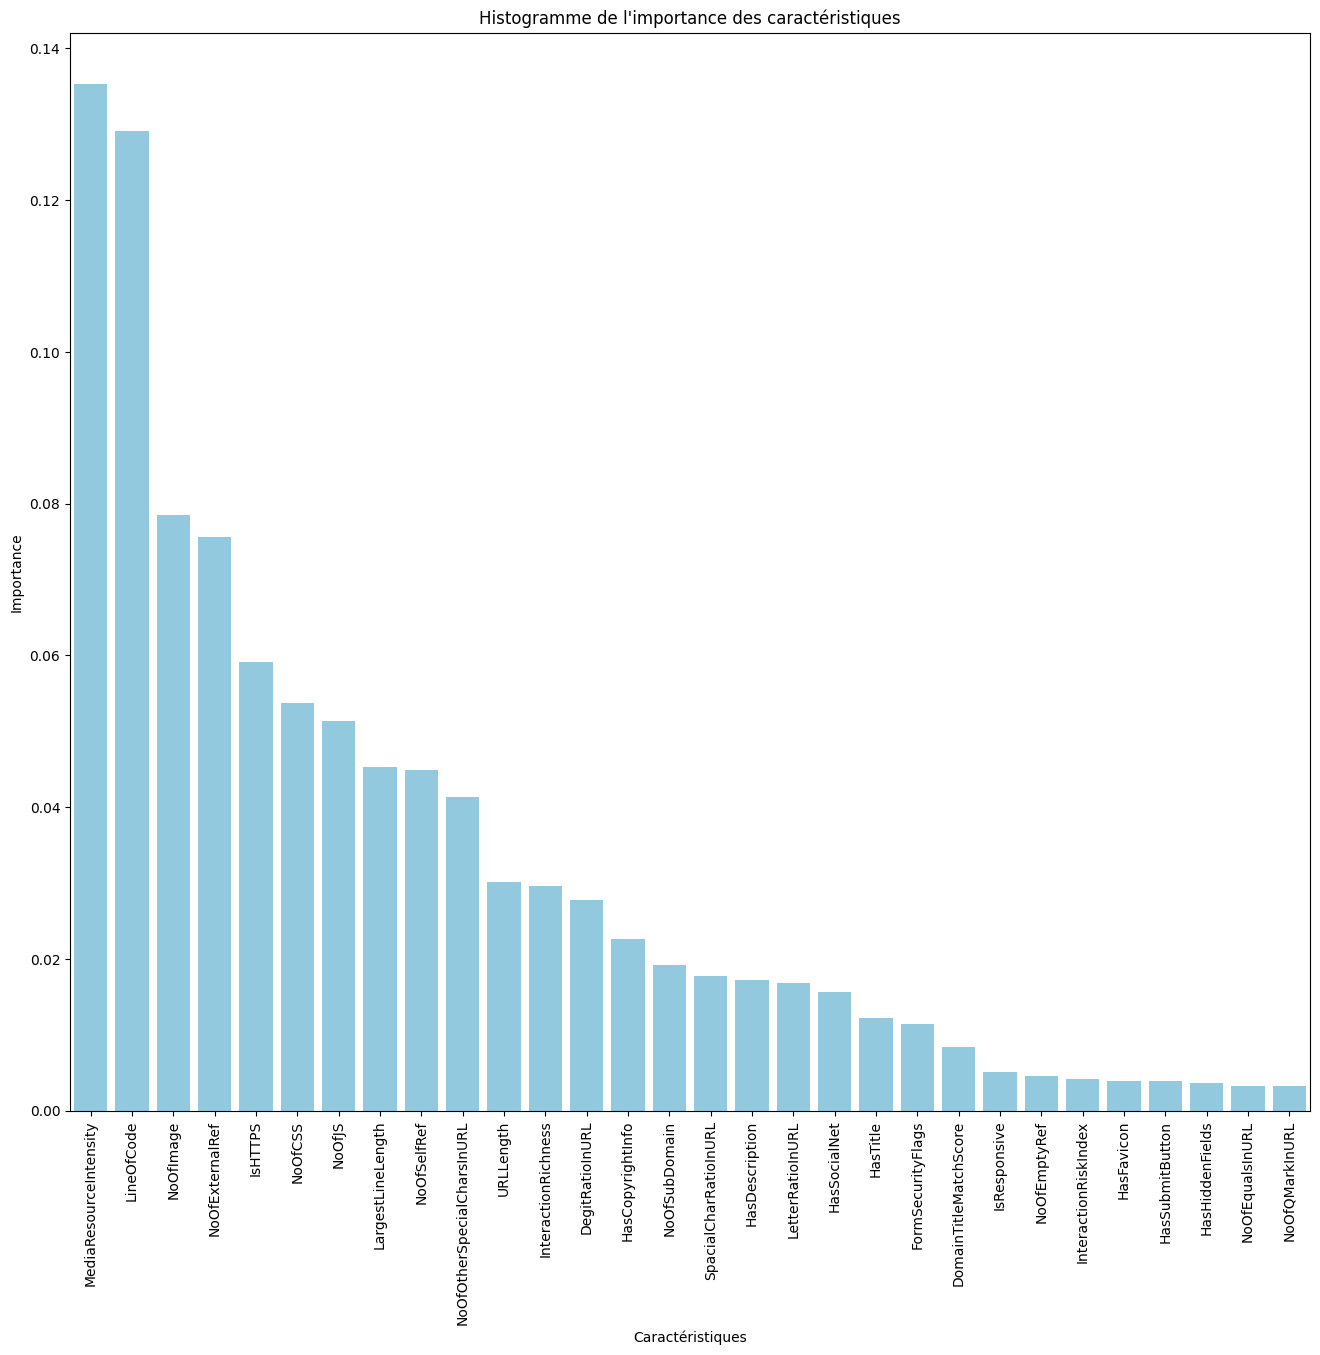

In [28]:
# Now we can show the feature ipportances
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=False).head(30)

plt.figure(figsize=(16, 14))
sns.barplot(data=importance_df_sorted, x="Feature", y="Importance", color="skyblue")
plt.title("Histogramme de l'importance des caractéristiques")
plt.xticks(rotation=90)
plt.ylabel("Importance")
plt.xlabel("Caractéristiques")
plt.show()

A lot of our created features seem to be important : MediaRousourceIntensity (the best one !), InteractionRichness, FormSecurityFlags and InteractionRiskIndex. As we are going to set a threshold to keep only the most important, some of them may be removed for the next training, but it's still good to know that our feature engineering has been very helpful !

Let's train the same model on only the most important features to see if we get similar scores :

In [31]:
threshold = 0.02
# Selecting features with importance > 0.02
features_selected = importance_df[importance_df['Importance']>threshold]['Feature']
X_train_selected = X_train[features_selected]
X_test_selected = X_test[features_selected]

# Scaling and encoding
# NEED TO RECOMPILE THE COMMON IMPORTS CELL TO INITIALIZE X_TRAIN ETC
categorical_features = X_train_selected.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train_selected.select_dtypes(exclude=['object']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),       
        ('cat', OneHotEncoder(), categorical_features)    
    ]
)

X_train_selected = preprocessor.fit_transform(X_train_selected)
X_test_selected = preprocessor.transform(X_test_selected)

rf_selected = RandomForestClassifier(n_estimators=100)
rf_selected.fit(X_train_selected, y_train)
y_pred = rf_selected.predict(X_test_selected)


f1_score = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)


F1 Score: 0.998000444345701
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     30308
           1       1.00      1.00      1.00     40430

    accuracy                           1.00     70738
   macro avg       1.00      1.00      1.00     70738
weighted avg       1.00      1.00      1.00     70738

[[30148   160]
 [    2 40428]]


Similar results. Let's do it with SVM :

In [33]:
threshold = 0.02
# Selecting features with importance > 0.02
features_selected = importance_df[importance_df['Importance']>threshold]['Feature']
X_train_selected = X_train[features_selected]
X_test_selected = X_test[features_selected]
X_train_selected = X_train_selected.select_dtypes(exclude='object')
X_test_selected = X_test_selected.select_dtypes(exclude='object')

# Scaling and encoding
# NEED TO RECOMPILE THE COMMON IMPORTS CELL TO INITIALIZE X_TRAIN ETC
scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

svm_selected = SVC(C=10, kernel='linear')
svm_selected.fit(X_train_selected, y_train)
y_pred = rf_selected.predict(X_test_selected)


f1_score = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)


F1 Score: 0.998000444345701
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     30308
           1       1.00      1.00      1.00     40430

    accuracy                           1.00     70738
   macro avg       1.00      1.00      1.00     70738
weighted avg       1.00      1.00      1.00     70738

[[30148   160]
 [    2 40428]]


A little bit worse but still similar (F1 score = 0.998 instead of 0.999). Really interesting !

### Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

# preprocess the data           
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()
X_train_lr = X_train_lr.select_dtypes(exclude='object')
X_test_lr = X_test_lr.select_dtypes(exclude='object')
# X_train_lr.drop(columns=already_encoded, inplace=True)
# X_test_lr.drop(columns=already_encoded, inplace=True)
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)


model = LogisticRegression()
model.fit(X_train_lr,y_train)

y_pred = model.predict(X_test_lr)
f1_score = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("précision du modèle")
print(f1_score)
print("Classification Report:")
print(class_report)
print("matrice de confusion")
print(conf_matrix)

précision du modèle
0.9981622324634567
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30308
           1       1.00      1.00      1.00     40430

    accuracy                           1.00     70738
   macro avg       1.00      1.00      1.00     70738
weighted avg       1.00      1.00      1.00     70738

matrice de confusion
[[30184   124]
 [    6 40424]]


With droping encoded_feature : 0.992
Without : 0.998

In [37]:
# we keep only important features
threshold = 0.02
# Selecting features with importance > 0.02
features_selected = importance_df[importance_df['Importance']>threshold]['Feature']
X_train_selected = X_train[features_selected]
X_test_selected = X_test[features_selected]
X_train_selected = X_train_selected.select_dtypes(exclude='object')
X_test_selected = X_test_selected.select_dtypes(exclude='object')


# sensitive to distance so data need to be scaled
scaler = StandardScaler()
scaler.fit_transform(X_train_selected)
scaler.transform(X_test_selected)

# model
model = LogisticRegression()
model.fit(X_train_selected,y_train)

y_pred = model.predict(X_test_selected)
f1_score = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("précision du modèle")
print(f1_score)
print("Classification Report:")
print(class_report)
print("matrice de confusion")
print(conf_matrix)

précision du modèle
0.9935678136220985
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     30308
           1       0.99      1.00      0.99     40430

    accuracy                           0.99     70738
   macro avg       0.99      0.99      0.99     70738
weighted avg       0.99      0.99      0.99     70738

matrice de confusion
[[29881   427]
 [   28 40402]]


c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Also good and similar to the previous ones.

### Naive Bayes

In [168]:
from sklearn.naive_bayes import GaussianNB

# Scaling and encoding
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),       
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)    
    ]
)

X_train = preprocessor.fit_transform(X_train).toarray()
X_test = preprocessor.transform(X_test).toarray()

model = GaussianNB()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
f1_score = accuracy_score(y_test, y_pred)

print("précision du modèle")
print(f1_score)
print("Classification Report:")
print(class_report)
print("matrice de confusion")
print(conf_matrix)


précision du modèle
0.8048573609658175
Classification Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81     30308
           1       1.00      0.66      0.79     40430

    accuracy                           0.80     70738
   macro avg       0.84      0.83      0.80     70738
weighted avg       0.86      0.80      0.80     70738

matrice de confusion
[[30230    78]
 [13726 26704]]


Worse than the other models.

### KNN

In [173]:
from sklearn.neighbors import KNeighborsClassifier

X_train_knn = X_train.select_dtypes(exclude='object') 
X_test_knn = X_test.select_dtypes(exclude='object') 


# sensitive to distance so data need to be scaled
scaler_knn = StandardScaler()
scaler_knn.fit_transform(X_train_knn)
scaler_knn.transform(X_test_knn)

# model
knn = KNeighborsClassifier()

# hyperparameters to tune
param_grid = {'n_neighbors': [1,2,3,4,5,10,15]}
grid_search = GridSearchCV(knn, param_grid, scoring='f1', cv=3)

# training 
grid_search.fit(X_train_knn, y_train)
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_knn)


conf_matrix_knn = confusion_matrix(y_test, y_pred)
class_report_knn = classification_report(y_test, y_pred)
f1score_knn = accuracy_score(y_test, y_pred)

print('nombre de voisin optimal')
print(grid_search.best_params_['n_neighbors'])
print("f1 score du modèle")
print(f1score_knn)
print("Classification Report:")
print(class_report_knn)
print("matrice de confusion")
print(conf_matrix_knn)

nombre de voisin optimal
1
f1 score du modèle
0.9889451214340241
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     30308
           1       0.98      1.00      0.99     40430

    accuracy                           0.99     70738
   macro avg       0.99      0.99      0.99     70738
weighted avg       0.99      0.99      0.99     70738

matrice de confusion
[[29569   739]
 [   43 40387]]


Not that bad, very better than the NB but a little bit worse than the other one.

### Ensemble Methods

#### Stacking with our best models

Let's stack the models with an accuracy >= 0.99 : a stacking model use the predictions made by the initial models to give a new prediction. Model quite easy to understand but very complex in fact.

WARNING : about 2 hours to compile this cell (with the first data set, but got f1 score = 0.9999).

In [174]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# we keep only important features
threshold = 0.02
# Selecting features with importance > 0.02
features_selected = importance_df[importance_df['Importance']>threshold]['Feature']
X_train_selected = X_train[features_selected]
X_test_selected = X_test[features_selected]
X_train_selected = X_train_selected.select_dtypes(exclude='object')
X_test_selected = X_test_selected.select_dtypes(exclude='object')


# sensitive to distance so data need to be scaled
scaler_knn = StandardScaler()
scaler_knn.fit_transform(X_train_selected)
scaler_knn.transform(X_test_selected)

# models 
estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=1)),
    ('svm', SVC(kernel='linear', C=10)),
    ('logistic_regression', LogisticRegression()),
    ('decision_tree', RandomForestClassifier(n_estimators=33)) # less than before because it's too long
]

# stacking
stacking_model = StackingClassifier(estimators=estimators, cv=3)
stacking_model.fit(X_train_selected, y_train)
y_pred = stacking_model.predict(X_test_selected)

# results
conf_matrix_stack = confusion_matrix(y_test, y_pred)
class_report_stack = classification_report(y_test, y_pred)
accuracy_stack = accuracy_score(y_test, y_pred)

print("précision du modèle")
print(accuracy_stack)
print("Classification Report:")
print(class_report_stack)
print("matrice de confusion")
print(conf_matrix_stack)


c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

précision du modèle
0.9990245695382962
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30308
           1       1.00      1.00      1.00     40430

    accuracy                           1.00     70738
   macro avg       1.00      1.00      1.00     70738
weighted avg       1.00      1.00      1.00     70738

matrice de confusion
[[30242    66]
 [    3 40427]]


The best f1 score we got but the model seems to be too complicated : more than 1 hour of training, combining several models but not much improvement.

## Selecting our model

After analyzing our data, we decided to train several machine learning models, using techniques such as a GridSearch to optimize some parameters. The best model, in term of score f1, is the stacking model combining a logistic regression, a svm, a random forest and a knn. This model obtains a f1 score of 0.999 (really close to 1).

However, we have other models that have a really good f1 score (0.998) such as the random forest, the logistic regression and a svm. As the challenge is based on f1 score, we would like to keep the stacking model, because it is the most efficient, but in a real case, in our opinion, it is better to keep the SVM trained on selected features because it is simple (in term of complexity) and really easy to introduce to someone. The stacking is far too complex for the added value it brings (only 0.001 of f1 score).

In a nutshell, the best model is the stacking one but, in our opinion, the logistic regression with all the data (simple model but a lot of data) or the SVM on the selected features (a little bit more complex but less data) seem to be the best choice in a real project. **We decided to keep the SVM on the selected features** just under this cell.

In [43]:
threshold = 0.02
# Selecting features with importance > 0.02
features_selected = importance_df[importance_df['Importance']>threshold]
features_selected.sort_values(by='Importance', ascending=False)

,Feature,Importance
41,MediaResourceIntensity,0.135308
13,LineOfCode,0.129121
33,NoOfImage,0.078520
38,NoOfExternalRef,0.075569
12,IsHTTPS,0.059132
34,NoOfCSS,0.053730
35,NoOfJS,0.051382
14,LargestLineLength,0.045303
36,NoOfSelfRef,0.044854
10,NoOfOtherSpecialCharsInURL,0.041313


We can see that 2 of our created features have been selected (MediaResourceIntensity and InteractionRichness), which shows how important they are comparing to the 30 non selected features, especially MediaResourceIntensity which is the most important feature according to our random forest estimator ! 

## Consideration of additional features

We already saw that some of the features we added have been really useful in the training phase (shown in the feature importance). Now, let's see how the removed features could have been helping.

In [57]:
def drop_add_columns_v2(df): 
    # ADDING FEATURES   
    # A high intensity of obfuscated character could be suspicious
    df['ObfuscationIntensity'] = df['NoOfObfuscatedChar'] / df['DomainLength']

    # Many interactions on a web page could be suspicious 
    # Phising web sites could use pop ups and hidden fields to trap the victimes
    df['InteractionRiskIndex'] = df['NoOfPopup'] + df['HasExternalFormSubmit'] + df['HasHiddenFields']

    # A high media resource intensity could show a well developed and professional website 
    df['MediaResourceIntensity'] = (df['NoOfImage'] + df['NoOfCSS'] + df['NoOfJS']) / df['URLLength']

    # Hackers use interaction tools to collect sensitive informations
    df['InteractionRichness'] = df['HasSubmitButton'] + df['HasPasswordField'] + df['HasSocialNet']
    df['FormSecurityFlags'] = df['HasSubmitButton'] + df['HasPasswordField'] + df['HasExternalFormSubmit'] + df['HasHiddenFields']

    # Hackers use redirection to trap people
    df['RedirectionRisk'] = df['NoOfURLRedirect'] + df['NoOfSelfRedirect']

    # DROPING FEATURES
    corelated_columns = ['HasObfuscation', 'NoOfObfuscatedChar','NoOfDegitsInURL','NoOfLettersInURL', 'DomainLength',
               'NoOfURLRedirect']
    df.drop(columns=corelated_columns, inplace=True)
    df.drop(columns=['Unnamed: 0','URL', 'FILENAME', 'Title', 'Domain'], inplace=True)

train_v2 = pd.read_csv('Training_for_evaluation.csv')
test_v2 = pd.read_csv('Testing_for_evaluation.csv')
drop_add_columns_v2(train_v2)
drop_add_columns_v2(test_v2)

Now let's see if there are some correlations between the previous features and the new ones :

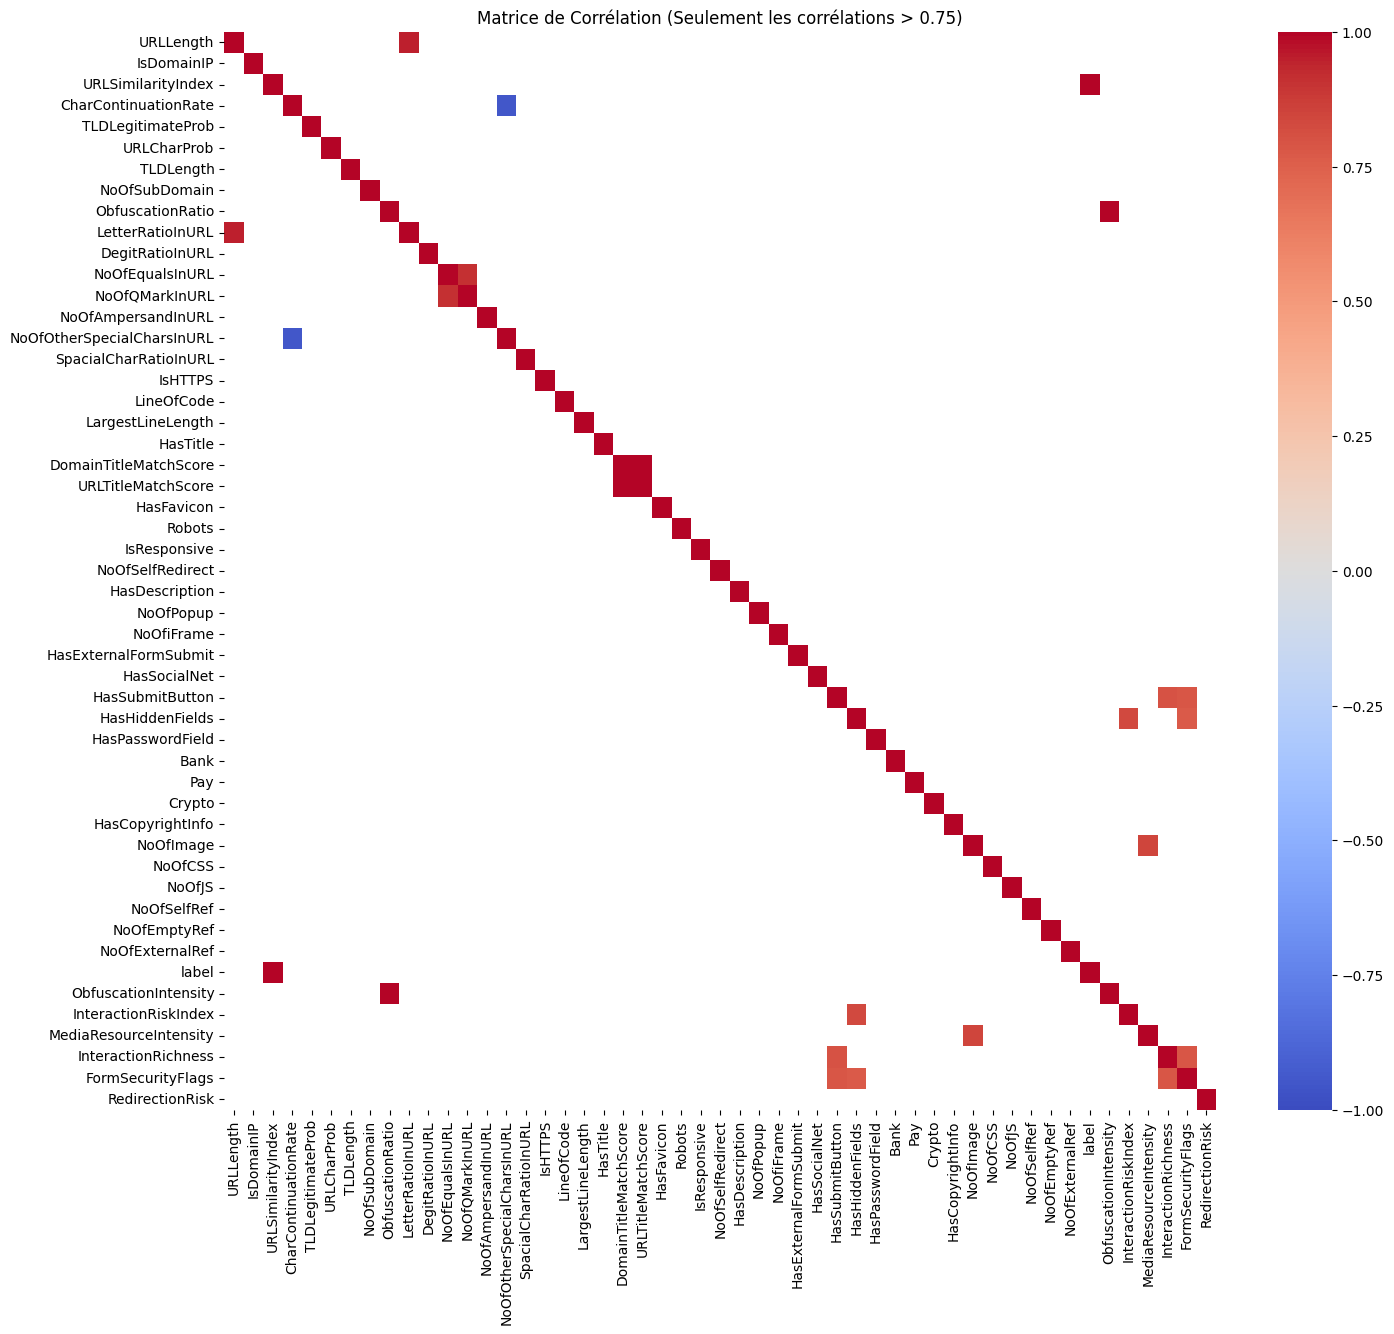

In [58]:
dfnum = train_v2.select_dtypes(exclude='object')
correlation_matrix_spearman = dfnum.corr(method='spearman')

filtered_correlation_matrix = correlation_matrix_spearman.where(np.abs(correlation_matrix_spearman) > 0.75)
plt.figure(figsize=(16, 14))
sns.heatmap(filtered_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, mask=filtered_correlation_matrix.isnull())
plt.title("Matrice de Corrélation (Seulement les corrélations > 0.75)")
plt.show()

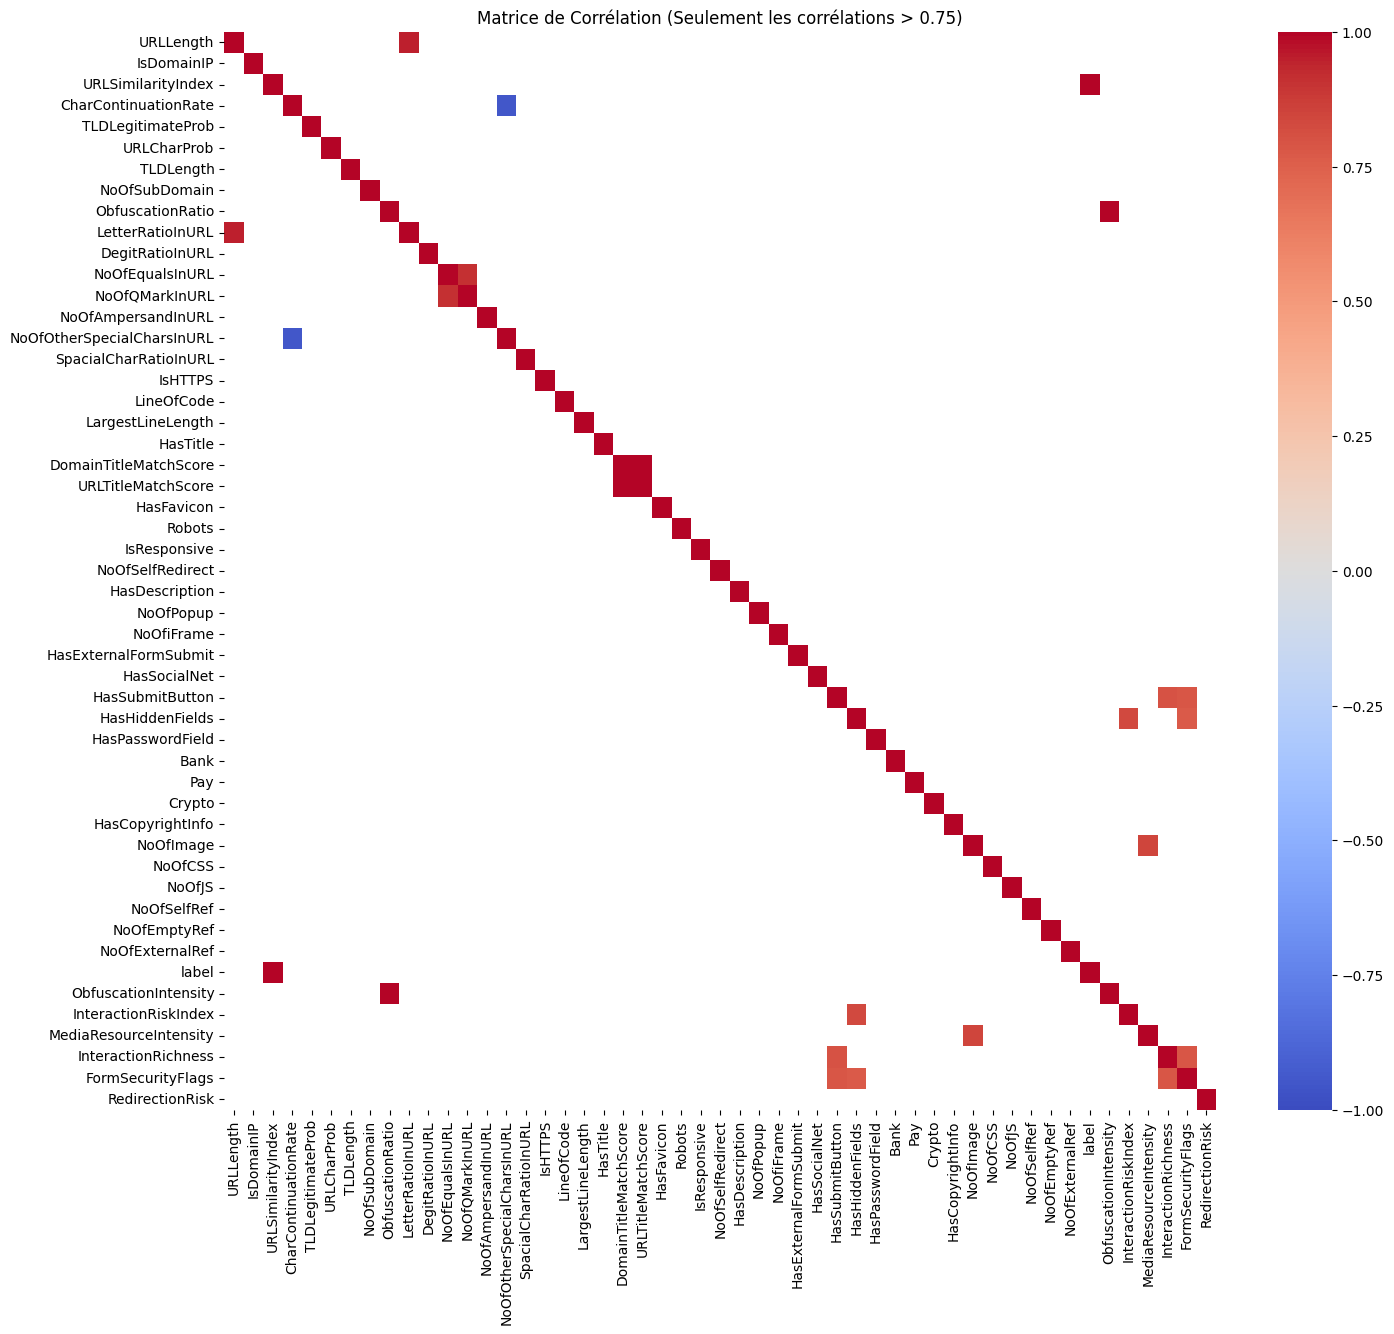

In [59]:
dfnum = train_v2.select_dtypes(exclude='object')
correlation_matrix_pearson = dfnum.corr(method='pearson')

filtered_correlation_matrix = correlation_matrix_spearman.where(np.abs(correlation_matrix_spearman) > 0.75)
plt.figure(figsize=(16, 14))
sns.heatmap(filtered_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, mask=filtered_correlation_matrix.isnull())
plt.title("Matrice de Corrélation (Seulement les corrélations > 0.75)")
plt.show()

In [60]:
correlation_matrix_pearson.loc['SpacialCharRatioInURL', 'CharContinuationRate']

-0.8142828068923373

What we can see :
- DomainTitleMatchScore (already used before so we'll drop it to keep the new feature) and URLTitleMatchScore are strongly correlated, so URLTitleMatchScore may not bring some information 
- SpacialCharRatioInURL (already used before so we'll drop it to keep the new feature) and CharContinuationRate are strongly correlated (negatively), so URLTitleMatchScore may not bring some information 
- URLSimilarityIndex is strongly correlated to the label: can be very usefull !
- URLCharProb and TLDLegitimateProb are not correlated to any features: they may bring some information.

In [61]:
train_v2.drop(columns=['DomainTitleMatchScore', 'SpacialCharRatioInURL'], inplace=True)
test_v2.drop(columns=['DomainTitleMatchScore', 'SpacialCharRatioInURL'], inplace=True)

Now let's train the same random forest and check the important features :

In [64]:
X_train = train_v2.drop(columns=['label'])  
y_train = train_v2['label']
X_test = test_v2.drop(columns=['label']) 
y_test = test_v2['label']

from sklearn.ensemble import RandomForestClassifier

# Scaling and encoding
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # bad if we don't scale     
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)    
    ]
)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


# model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

f1_score = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_score}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

F1 Score: 0.9998763447508346
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30308
           1       1.00      1.00      1.00     40430

    accuracy                           1.00     70738
   macro avg       1.00      1.00      1.00     70738
weighted avg       1.00      1.00      1.00     70738

[[30298    10]
 [    0 40430]]


In [65]:
# How to get the initial feature names ?
encoder = preprocessor.transformers_[1][1] 
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
numeric_feature_names = numeric_features
feature_names = numeric_feature_names + list(encoded_feature_names)

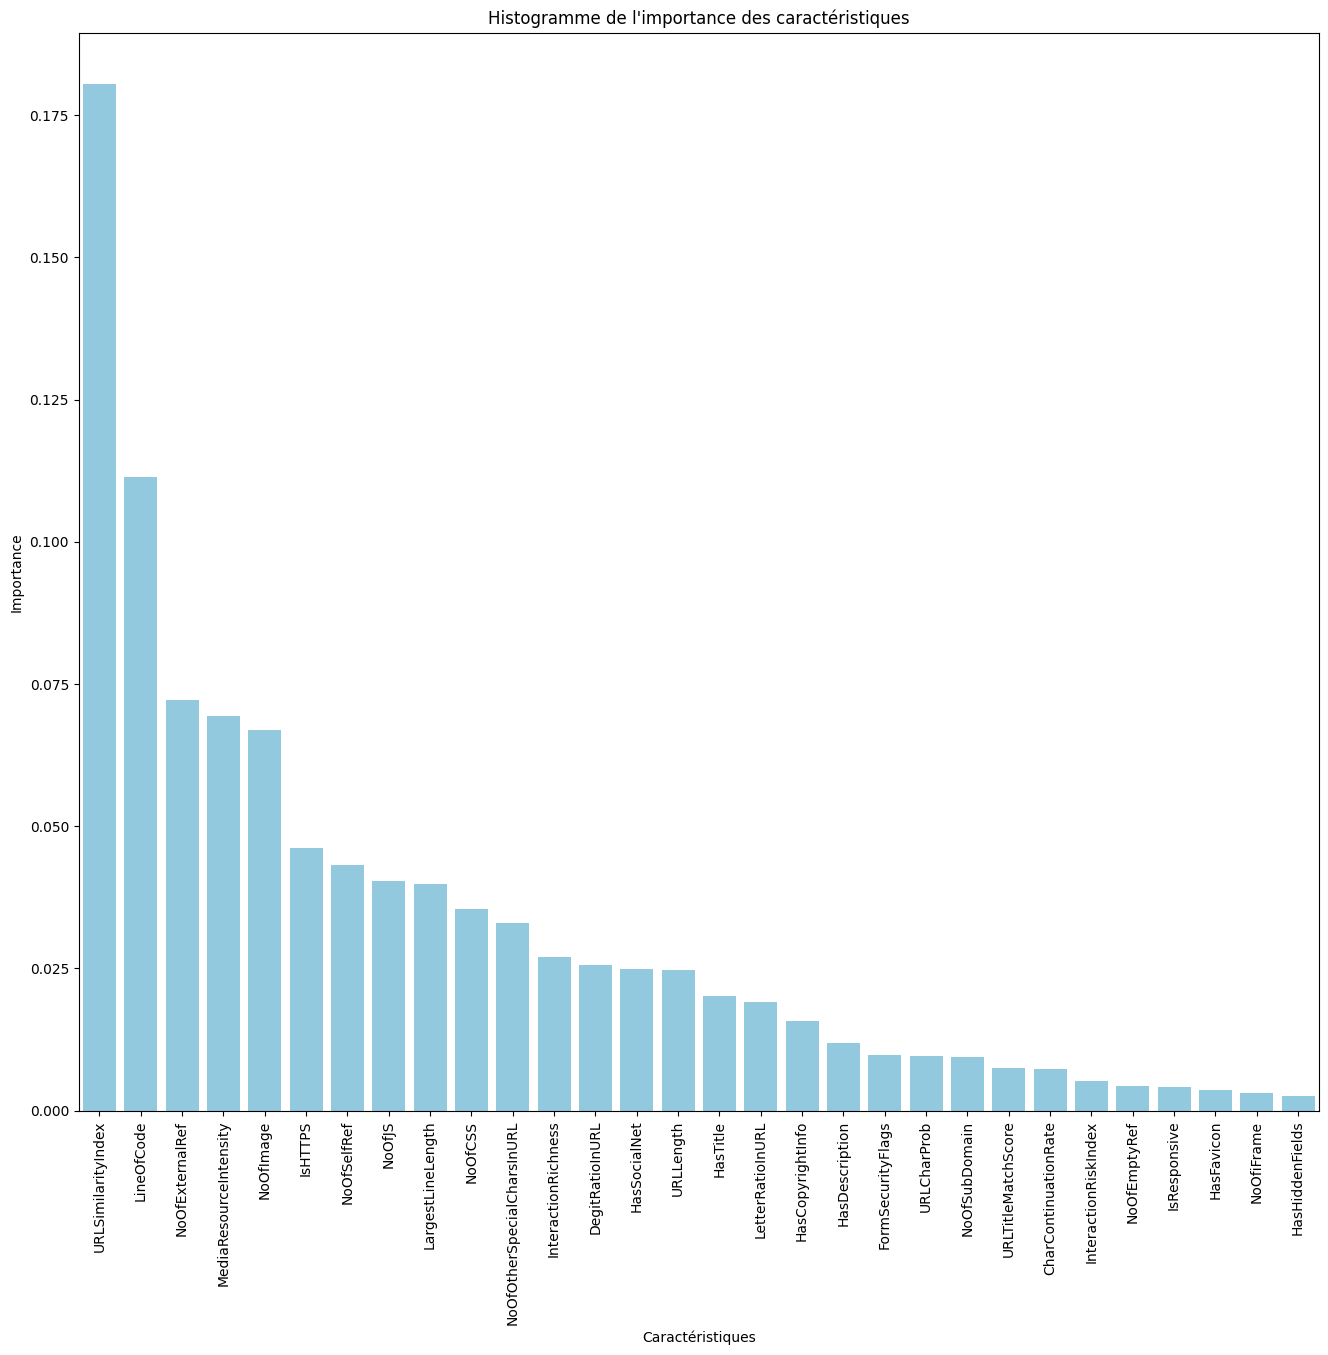

In [66]:
# Now we can show the feature ipportances
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=False).head(30)

plt.figure(figsize=(16, 14))
sns.barplot(data=importance_df_sorted, x="Feature", y="Importance", color="skyblue")
plt.title("Histogramme de l'importance des caractéristiques")
plt.xticks(rotation=90)
plt.ylabel("Importance")
plt.xlabel("Caractéristiques")
plt.show()

As expected, URLSimilarityIndex is the most important features and has helped to improve the model's performance (f1 score : 0.998 -> 0.9998). URLCharProb and CharContinuationRate also appear on the plot but they are far from the most important ones. Some of the engineered features are still here : MediaResourceIntensity remains among the best ones, InteractionRichness is still important, and some other (FormSecurityFlags, InteractionRiskIndex) are present but don't show a great importance.

In conclusion, only URLSimilarityIndex shows a huge importance in the training process (as expected because of its strong correlation with the target). Our engineered features remain important comparing to the removed features.